In [1]:
#initializing workspace
import pandas as pd
import matplotlib.pyplot as plt
import trxtools as tt
import os
from pyCRAC.Parsers import GTF2
import pyBigWig
import numpy as np
from trxtools.BigWig import *
from scipy.signal import argrelextrema

pathTAB = "../seq_references/Saccharomyces_cerevisiae.EF4.74.dna.toplevel.shortChrNames.tab"
pathGTF = "../seq_references/Saccharomyces_cerevisiae.EF4.74.shortChNames_with_PolIII_transcripts_extended_slop_intergenic_sort.gtf"
gtf = GTF2.Parse_GTF()
gtf.read_GTF(pathGTF)
gtf.read_TAB(pathTAB)

sequences = pd.read_csv(pathTAB, sep='\t',names=['chr','sequence'],index_col=0)
chr_len = sequences['sequence'].str.len()

pathDir = "../04_BigWig/"
pathMeta = "../06_metadata/"

dinucleotides = pd.read_csv(pathMeta+'/properties_of_dinucleotides.csv', index_col=0)
dinucleotides.index = dinucleotides.reset_index().index.astype(str)+"_"+dinucleotides.index

cleavage_sites = {"5' end" : (300),
                   'A0' : (300+609),
                   'A1' : (300+700),
                   'D'  : (300+2500),
                   'A2' : (300+2712),
                   'A3' : (300+2784),
                   'B1L': (300+2855),
                   'B1S': (300+2861),
                   'E'  : (300+3019),
                   'C1' : (300+3251),
                   'B2' : (300+6647),
                   'B0-1' : (300+6661),
                   'B0-2' : (300+6697),
                   'T1' : (300+6739)}

print(gtf.strand("RDN37-1"), gtf.chromosome("RDN37-1"), gtf.chromosomeCoordinates("RDN37-1"))
print(gtf.strand("RDN37-2"), gtf.chromosome("RDN37-2"), gtf.chromosomeCoordinates("RDN37-2"))

- chrXII (451785, 457732)
- chrXII (460922, 466869)


In [2]:
flank = 1000

seq1_flank = tt.methods.reverse_complement(sequences.loc['chrXII'][0][451785-flank:457732+flank])
seq2_flank = tt.methods.reverse_complement(sequences.loc['chrXII'][0][460922-flank:466869+flank])

#loading datasets

data_files_raw = [f for f in os.listdir(pathDir) if 'raw' in f and "bw" in f]
data_files_5end = [f for f in os.listdir(pathDir) if 'PROFILE_5end' in f and "bw" in f]
data_files_3end = [f for f in os.listdir(pathDir) if 'PROFILE_3end' in f and "polyA" not in f and "bw" in f]
data_files_polyA = [f for f in os.listdir(pathDir) if 'PROFILE_3end' in f and "polyA" in f and "bw" in f]

print(len(os.listdir(pathDir)))
print(len(data_files_raw))
print(len(data_files_5end))
print(len(data_files_3end))
print(len(data_files_polyA))

df01a_RDN371_datasets_3end = geneFromBigWig(gene_name="RDN37-1", data_path=pathDir, data_files=data_files_3end, gtf=gtf,ranges=flank)
s1_RDN371_sequence = df01a_RDN371_datasets_3end['nucleotide'] #kee[ for future use
df01b_RDN372_datasets_3end = geneFromBigWig(gene_name="RDN37-2", data_path=pathDir, data_files=data_files_3end, gtf=gtf,ranges=flank)
df01_RDN37_3end = df01a_RDN371_datasets_3end.drop('nucleotide',axis='columns') + df01b_RDN372_datasets_3end.drop('nucleotide',axis='columns')

df02a_RDN371_datasets_5end = geneFromBigWig(gene_name="RDN37-1", data_path=pathDir, data_files=data_files_5end, gtf=gtf,ranges=flank)
df02b_RDN372_datasets_5end = geneFromBigWig(gene_name="RDN37-2", data_path=pathDir, data_files=data_files_5end, gtf=gtf,ranges=flank)
df02_RDN37_5end = df02a_RDN371_datasets_5end.drop('nucleotide',axis='columns') + df02b_RDN372_datasets_5end.drop('nucleotide',axis='columns')

df03a_RDN371_datasets_polyA = geneFromBigWig(gene_name="RDN37-1", data_path=pathDir, data_files=data_files_polyA, gtf=gtf,ranges=flank)
df03b_RDN372_datasets_polyA = geneFromBigWig(gene_name="RDN37-2", data_path=pathDir, data_files=data_files_polyA, gtf=gtf,ranges=flank)
df03_RDN37_polyA = df03a_RDN371_datasets_polyA.drop('nucleotide',axis='columns') + df03b_RDN372_datasets_polyA.drop('nucleotide',axis='columns')

df04a_RDN371_datasets_raw = geneFromBigWig(gene_name="RDN37-1", data_path=pathDir, data_files=data_files_raw, gtf=gtf,ranges=flank)
df04b_RDN372_datasets_raw = geneFromBigWig(gene_name="RDN37-2", data_path=pathDir, data_files=data_files_raw, gtf=gtf,ranges=flank)
df04_RDN37_raw = df04a_RDN371_datasets_raw.drop('nucleotide',axis='columns') + df04b_RDN372_datasets_raw.drop('nucleotide',axis='columns')

df05_folding = foldingFromBigWig("RDN37-1",data_path=pathMeta,data_files=["w65_dG"], gtf=gtf,ranges=flank,range5end=700)

824
162
162
162
162


/home/tturowski/TurowskiLab/trxtools/trxtools/BigWig.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t1[name][0:ranges-range5end+int(name.replace("w","").replace("_dG",""))] = np.nan #remove folding for the 5'end


# Fig 4 A-D Rat1 and Mtr4

In [3]:
df11_Rpa190_3end = tt.profiles.preprocess(df01_RDN37_3end,
                                     let_in=['Rpa190HTP'], 
                                     let_out=['hmo1','0s','25rDNA','UVA'],stats=True)

df13_Rat1_read = tt.profiles.preprocess(df04_RDN37_raw,
                                     let_in=['Rat1'],stats=True)

df14_Rat1_5end = tt.profiles.preprocess(df02_RDN37_5end,
                                     let_in=['Rat1'],stats=True)

# df15_Rat1_3end = tt.profiles.preprocess(df01_RDN37_3end,
#                                      let_in=['Rat1'],stats=True)

df16_Rat1_polyA = tt.profiles.preprocess(df03_RDN37_polyA,
                                     let_in=['Rat1'],stats=True)

df17_Mtr4_read = tt.profiles.preprocess(df04_RDN37_raw,
                                     let_in=['Mtr4','wt'],stats=True)

# df18_Mtr4_5end = tt.profiles.preprocess(df02_RDN37_5end,
#                                      let_in=['Mtr4','wt'],stats=True)

df19_Mtr4_3end = tt.profiles.preprocess(df01_RDN37_3end,
                                     let_in=['Mtr4','wt'],stats=True)

df20_Mtr4_polyA = tt.profiles.preprocess(df03_RDN37_polyA,
                                     let_in=['Mtr4','wt'],stats=True)

df21_Mtr4Rrp44exo_3end = tt.profiles.preprocess(df01_RDN37_3end,
                                     let_in=['Mtr4','Rrp44-exo'],stats=True)

df22_Mtr4Rrp44exo_polyA = tt.profiles.preprocess(df03_RDN37_polyA,
                                     let_in=['Mtr4','Rrp44-exo'],stats=True)

df23_Mtr4Rrp44exo_read = tt.profiles.preprocess(df04_RDN37_raw,
                                     let_in=['Mtr4','Rrp44-exo'],stats=True)


/home/tturowski/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


Experiments: 
['XX000000_Rpa190HTP_wt_none_4_PROFILE_3end', 'XX000000_Rpa190HTP_wt_none_3_PROFILE_3end', 'XX000000_Rpa190HTP_wt_none_1_PROFILE_3end', 'XX000000_Rpa190HTP_wt_none_5_PROFILE_3end', 'XX000000_Rpa190HTP_wt_none_2_PROFILE_3end', 'XX000000_Rpa190HTP_wt_none_6_PROFILE_3end']
Experiments: 
['SG120826_Rat1HTP_wt_none_5_default_raw', 'SG120826_Rat1HTP_wt_none_11_default_raw']
Experiments: 
['SG120826_Rat1HTP_wt_none_11_default_PROFILE_5end', 'SG120826_Rat1HTP_wt_none_5_default_PROFILE_5end']
Experiments: 
['SG120826_Rat1HTP_wt_none_5_default_PROFILE_3end_polyA', 'SG120826_Rat1HTP_wt_none_11_default_PROFILE_3end_polyA']
Experiments: 
['CDF000002_Mtr4HTP_wt_none_2_raw', 'CDF000001_Mtr4HTP_wt_none_1_raw']
Experiments: 
['CDF000002_Mtr4HTP_wt_none_2_PROFILE_3end', 'CDF000001_Mtr4HTP_wt_none_1_PROFILE_3end']
Experiments: 
['CDF000001_Mtr4HTP_wt_none_1_PROFILE_3end_polyA', 'CDF000002_Mtr4HTP_wt_none_2_PROFILE_3end_polyA']
Experiments: 
['CDF000002_Mtr4HTP_Rrp44-exo_none_2_PROFILE_3end'

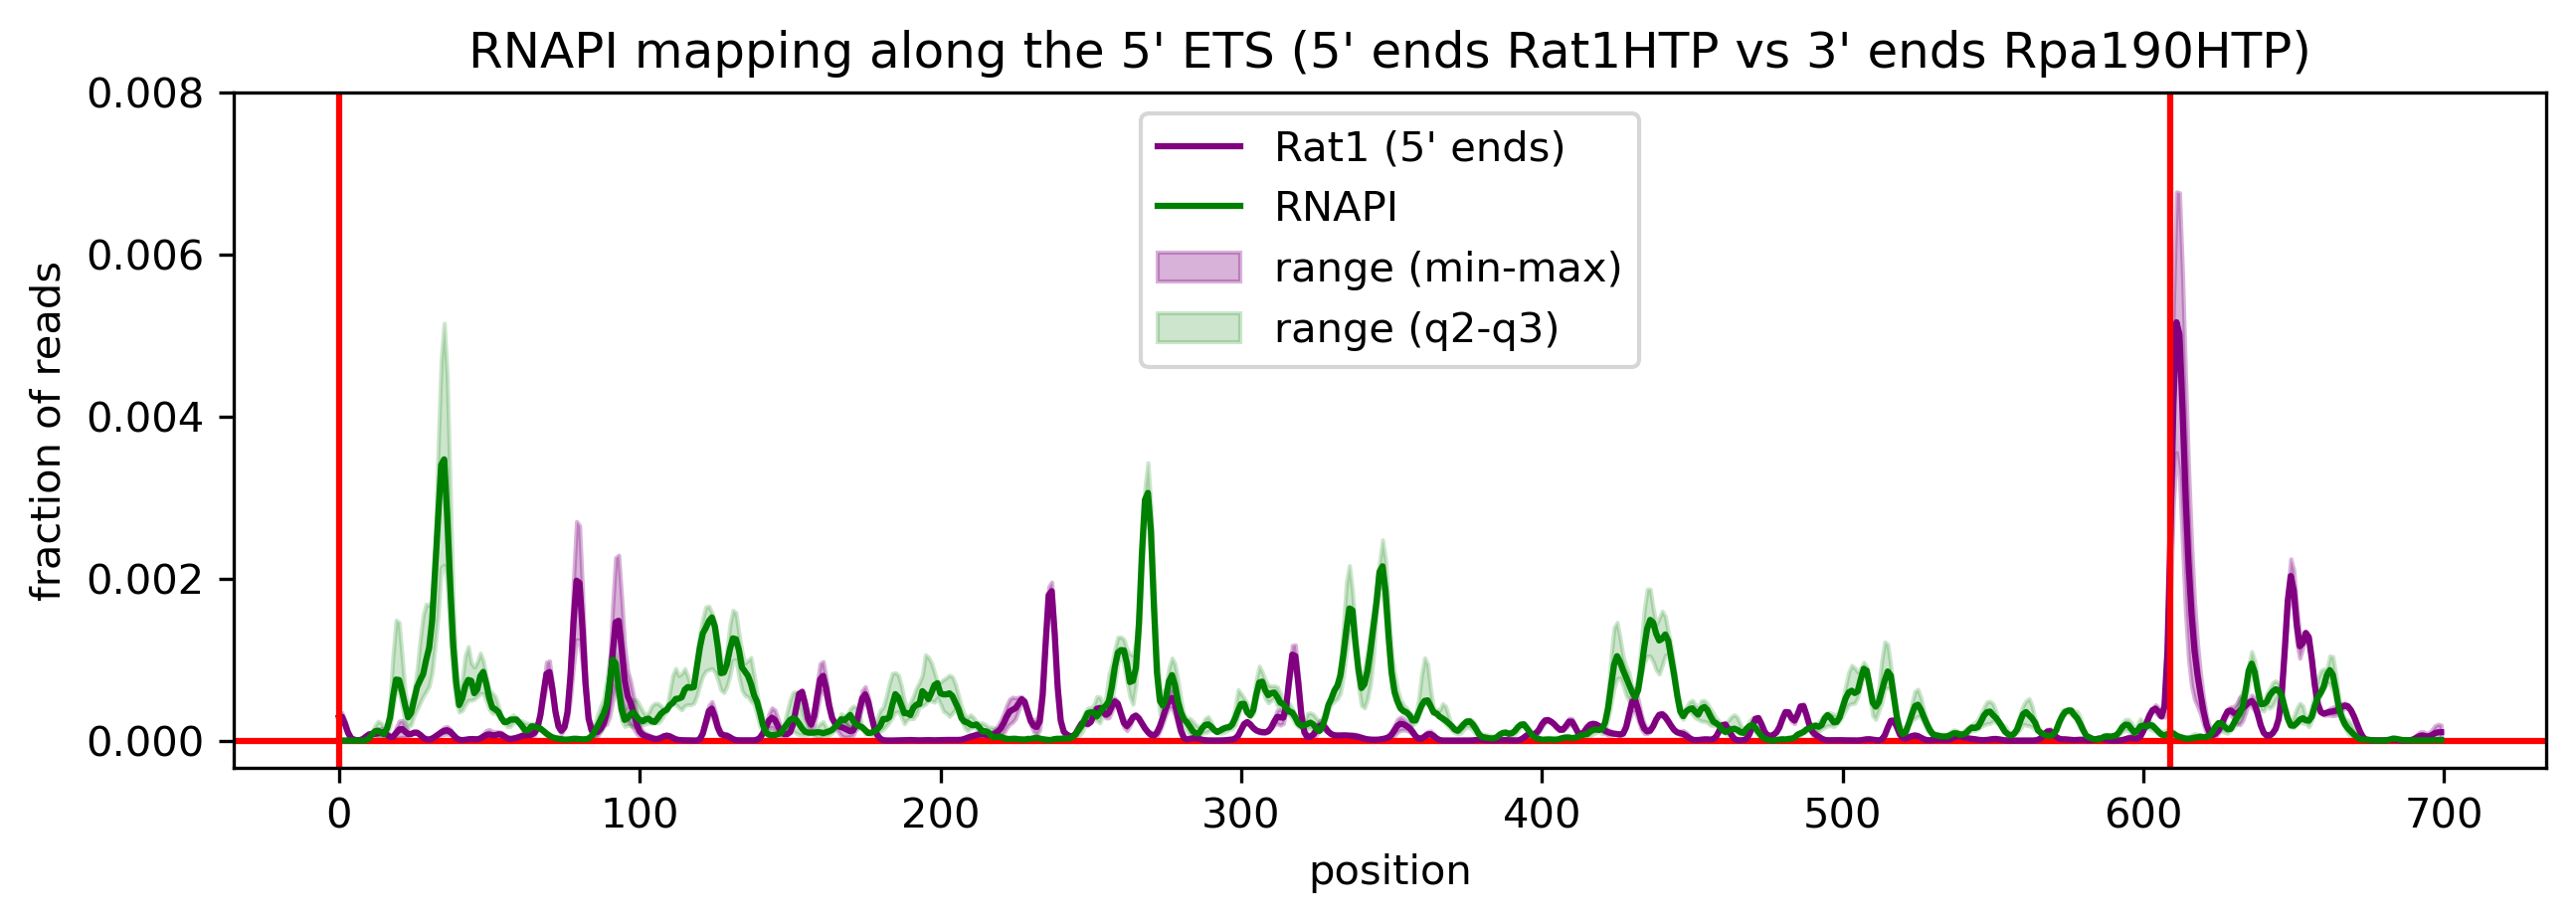

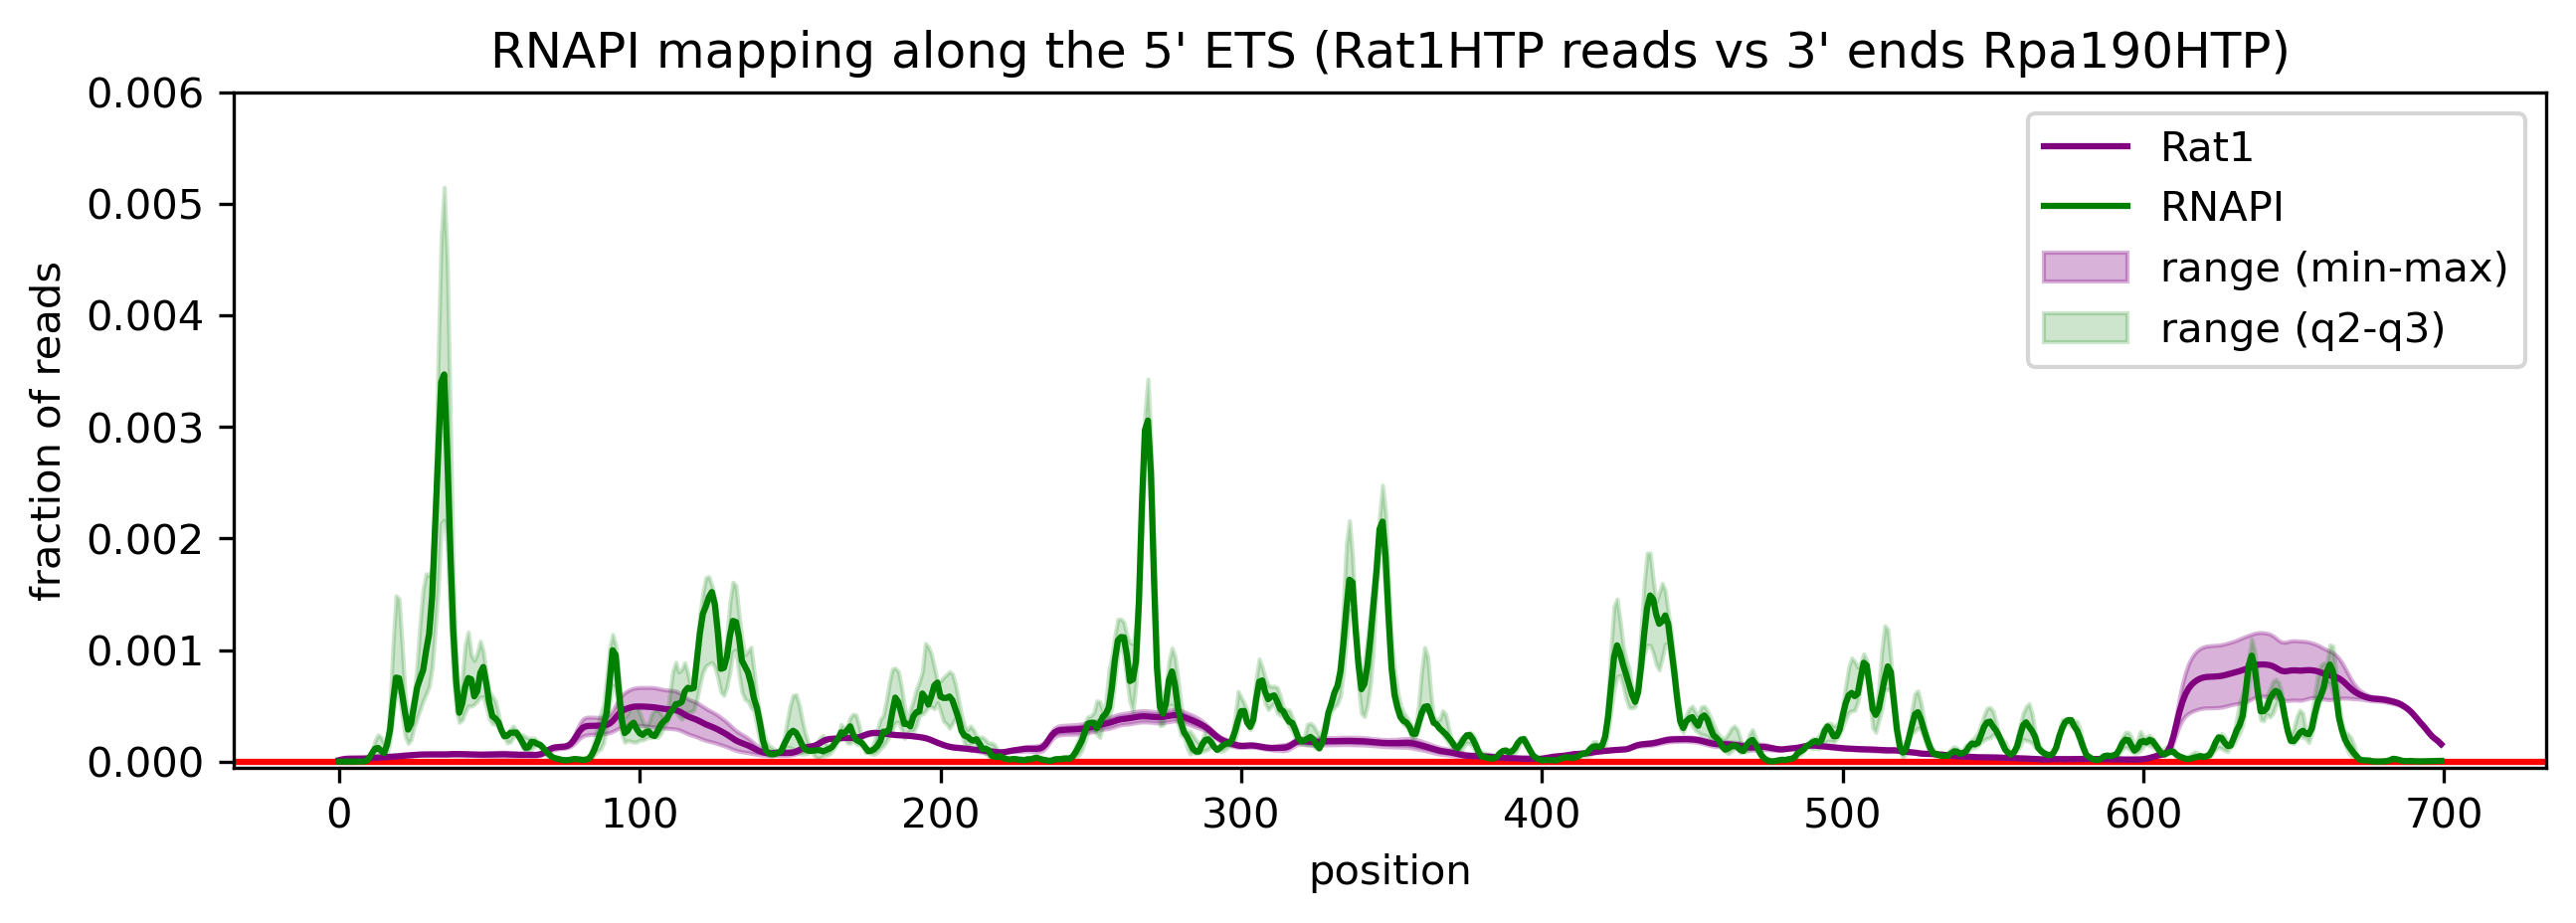

In [4]:
tt.plotting.plot_to_compare(ref=df11_Rpa190_3end, df=df14_Rat1_5end,figsize=(10,3),ref_label="RNAPI",label="Rat1 (5' ends)",
                           color2="purple",
                           title="RNAPI mapping along the 5' ETS (5' ends Rat1HTP vs 3' ends Rpa190HTP)",
                           dpi=300,offset=300, ylim=(None,0.008),
                           start=0+300, stop=700+300,
                           h_lines=[i-300 for i in cleavage_sites.values()],
                           fname='Fig_4A.png')

tt.plotting.plot_to_compare(ref=df11_Rpa190_3end, df=df13_Rat1_read,figsize=(10,3),ref_label="RNAPI",label="Rat1",
                           title="RNAPI mapping along the 5' ETS (Rat1HTP reads vs 3' ends Rpa190HTP)",
                           color2="purple",
                           dpi=300,offset=300, ylim=(None,0.006),
                           start=0+300, stop=700+300,
                           fname='Fig_S4A.png')

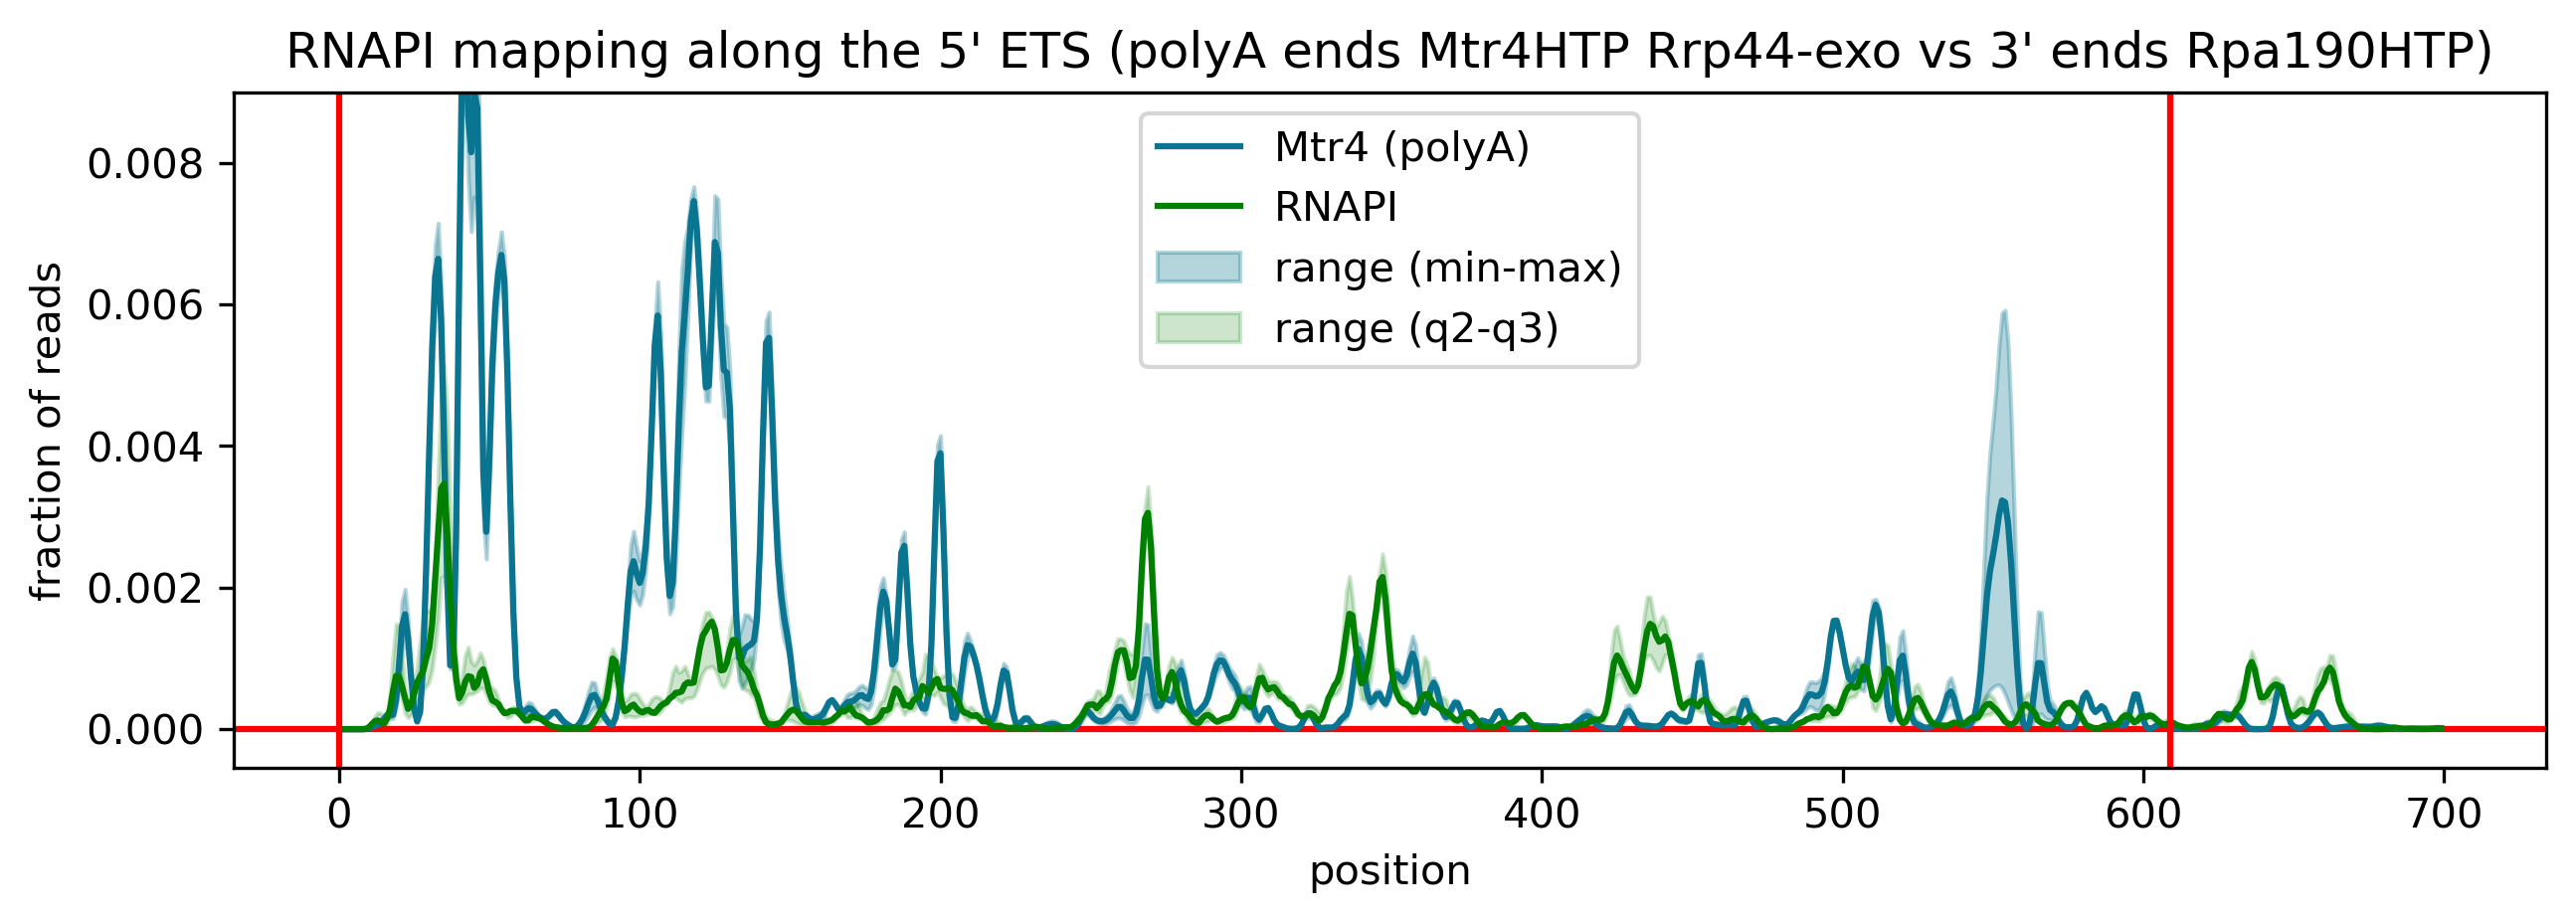

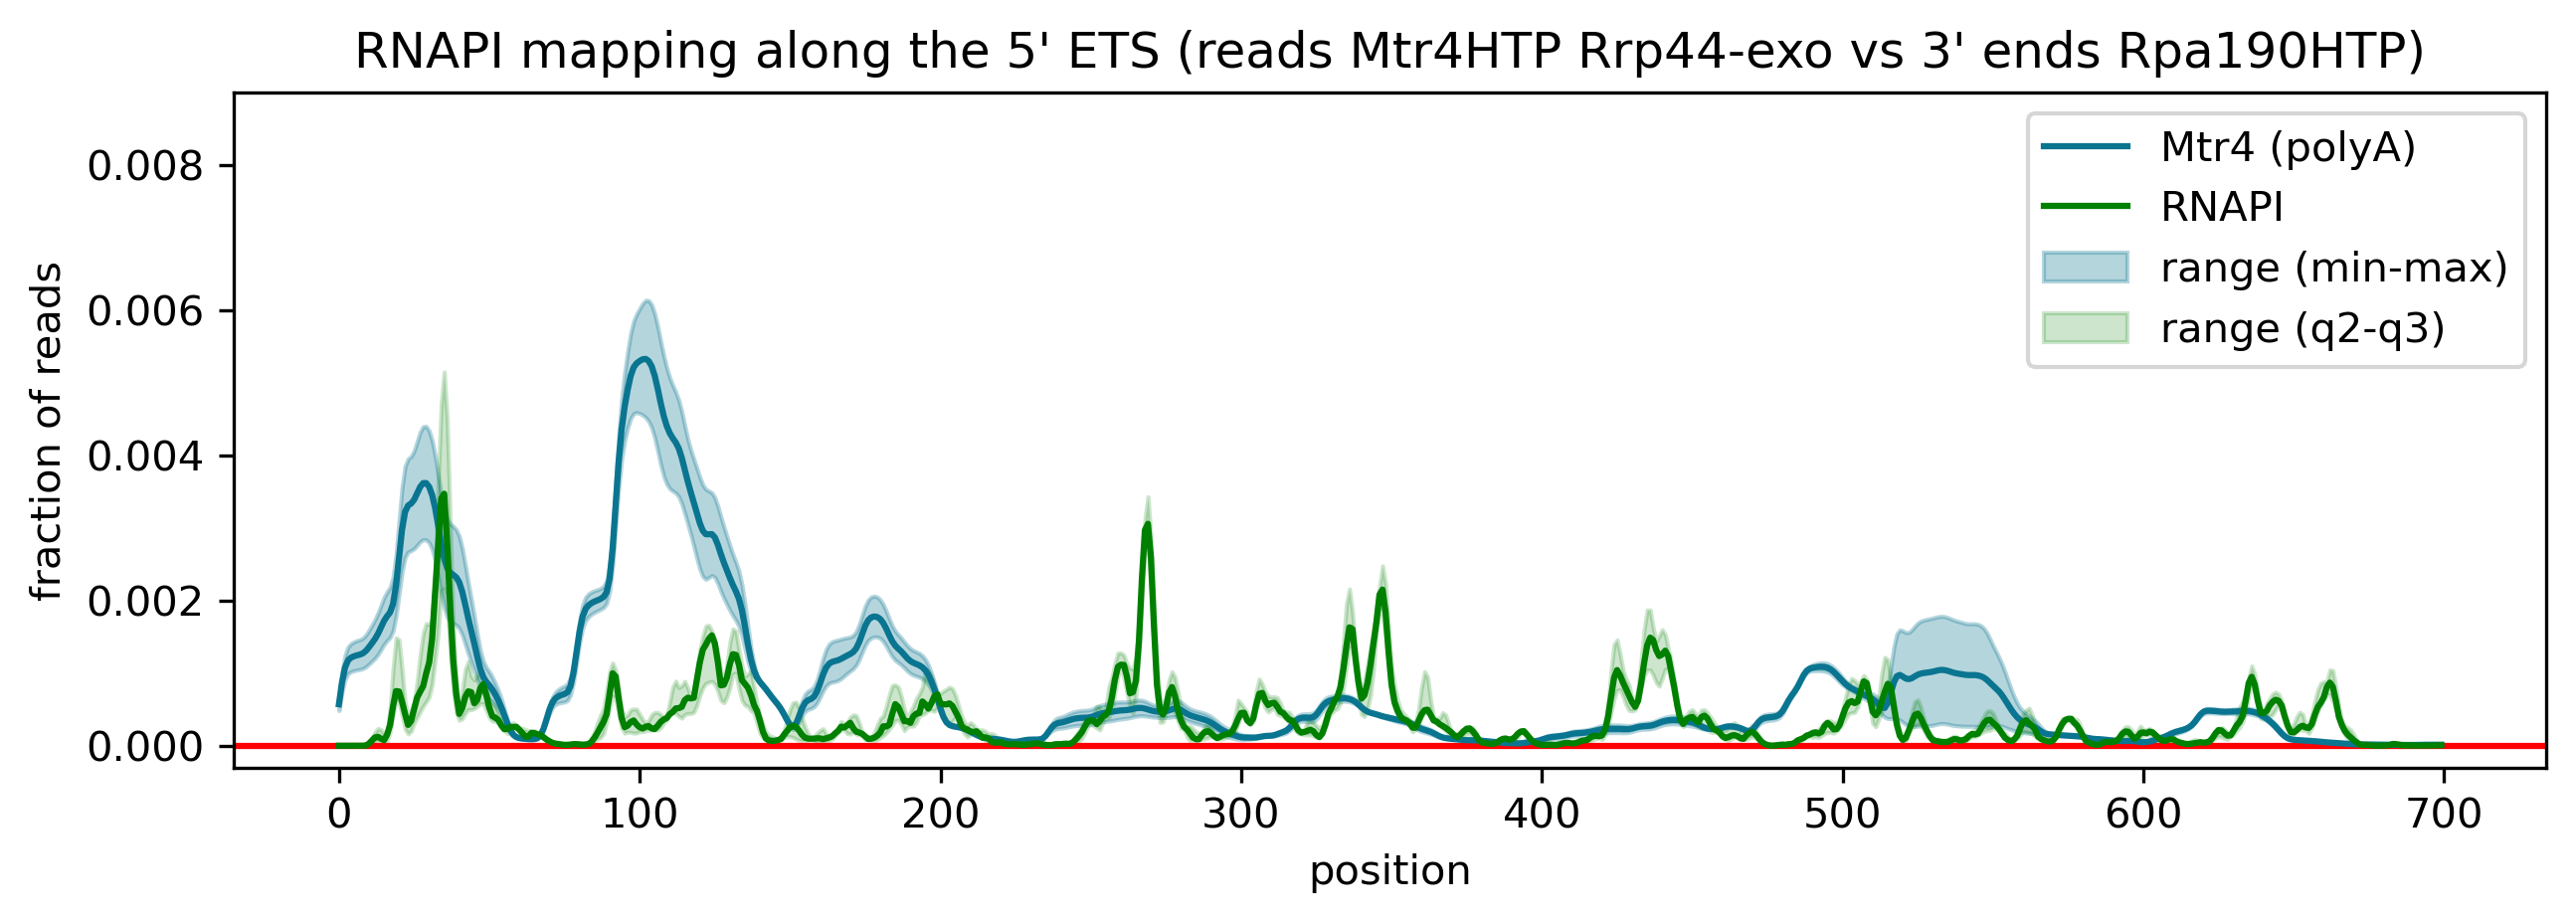

In [5]:
tt.plotting.plot_to_compare(ref=df11_Rpa190_3end, df=df22_Mtr4Rrp44exo_polyA,figsize=(10,3),ref_label="RNAPI",label="Mtr4 (polyA)",
                           title="RNAPI mapping along the 5' ETS (polyA ends Mtr4HTP Rrp44-exo vs 3' ends Rpa190HTP)",
                           dpi=300,offset=300, ylim=(None,0.009),
                           color2="#0A7590",
                           start=0+300, stop=700+300,
                           h_lines=[i-300 for i in cleavage_sites.values()],
                           fname='Fig_4C.png')

tt.plotting.plot_to_compare(ref=df11_Rpa190_3end, df=df23_Mtr4Rrp44exo_read,figsize=(10,3),ref_label="RNAPI",label="Mtr4 (polyA)",
                           title="RNAPI mapping along the 5' ETS (reads Mtr4HTP Rrp44-exo vs 3' ends Rpa190HTP)",
                           dpi=300,offset=300, ylim=(None,0.009),
                           color2="#0A7590",
                           start=0+300, stop=700+300,
                           fname='Fig_S4C.png')

In [6]:
peaks = tt.profiles.findPeaks(df11_Rpa190_3end['median'][:7200],order=45,window=80)
print(peaks)

df00_ref=pd.read_csv("../06_metadata/RDN37_reference_collapsed.csv", index_col=0)
loc_extr = argrelextrema(data=df00_ref.rolling(80,win_type="blackman",center=True).mean()['median'][:7200].to_numpy(), comparator=np.greater, order=50)[0]

print(len(peaks))
print(len(loc_extr))

[336, 425, 495, 568, 643, 737, 810, 947, 1094, 1169, 1372, 1502, 1561, 1724, 1827, 1902, 2049, 2123, 2249, 2347, 2500, 2598, 2686, 2789, 2908, 2977, 3074, 3258, 3339, 3472, 3640, 3795, 3903, 4018, 4103, 4282, 4363, 4497, 4578, 4650, 4769, 4910, 5041, 5102, 5157, 5237, 5416, 5686, 5752, 5873, 5938, 6107, 6224, 6323, 6495, 6594, 6697, 6796, 6910, 7027]
60
52


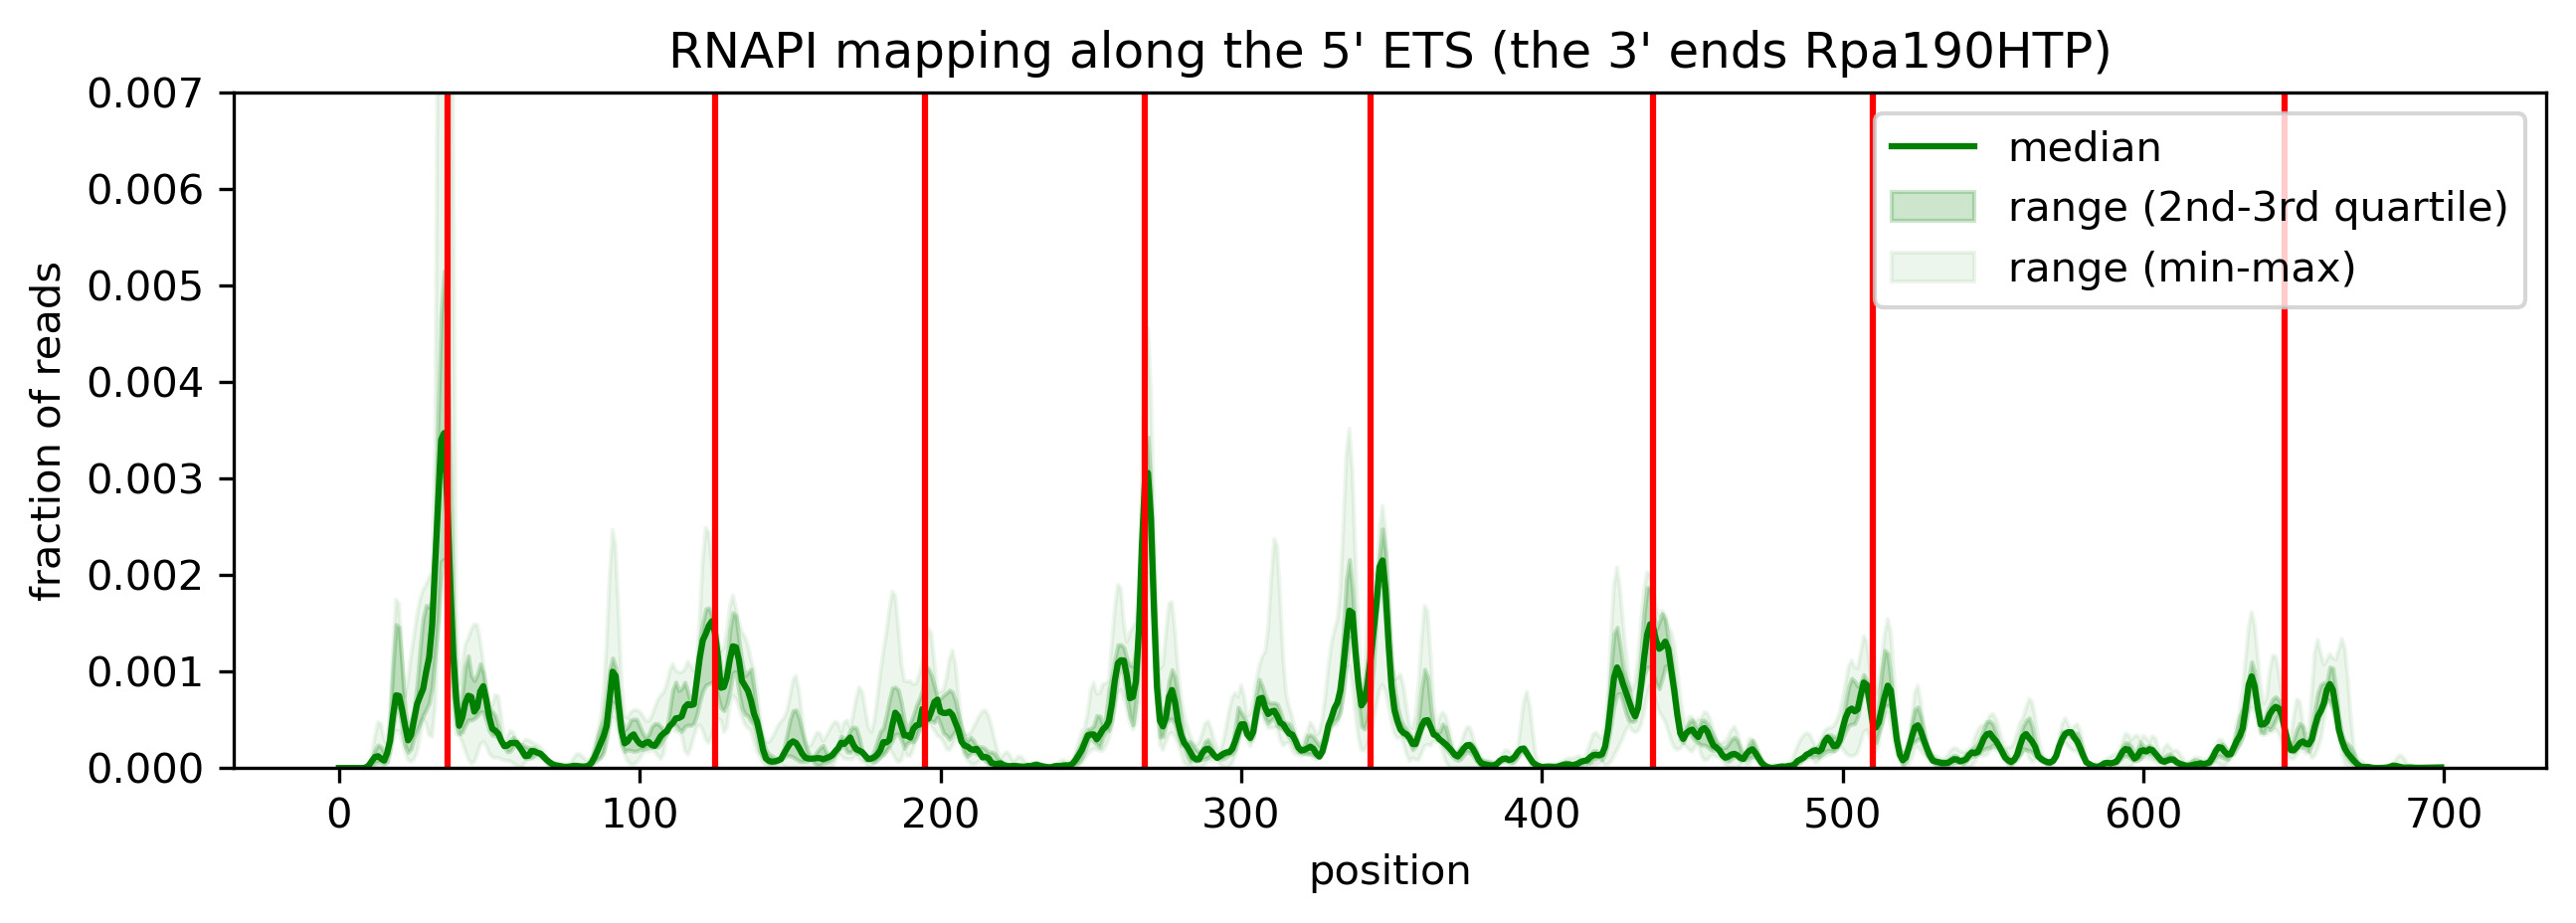

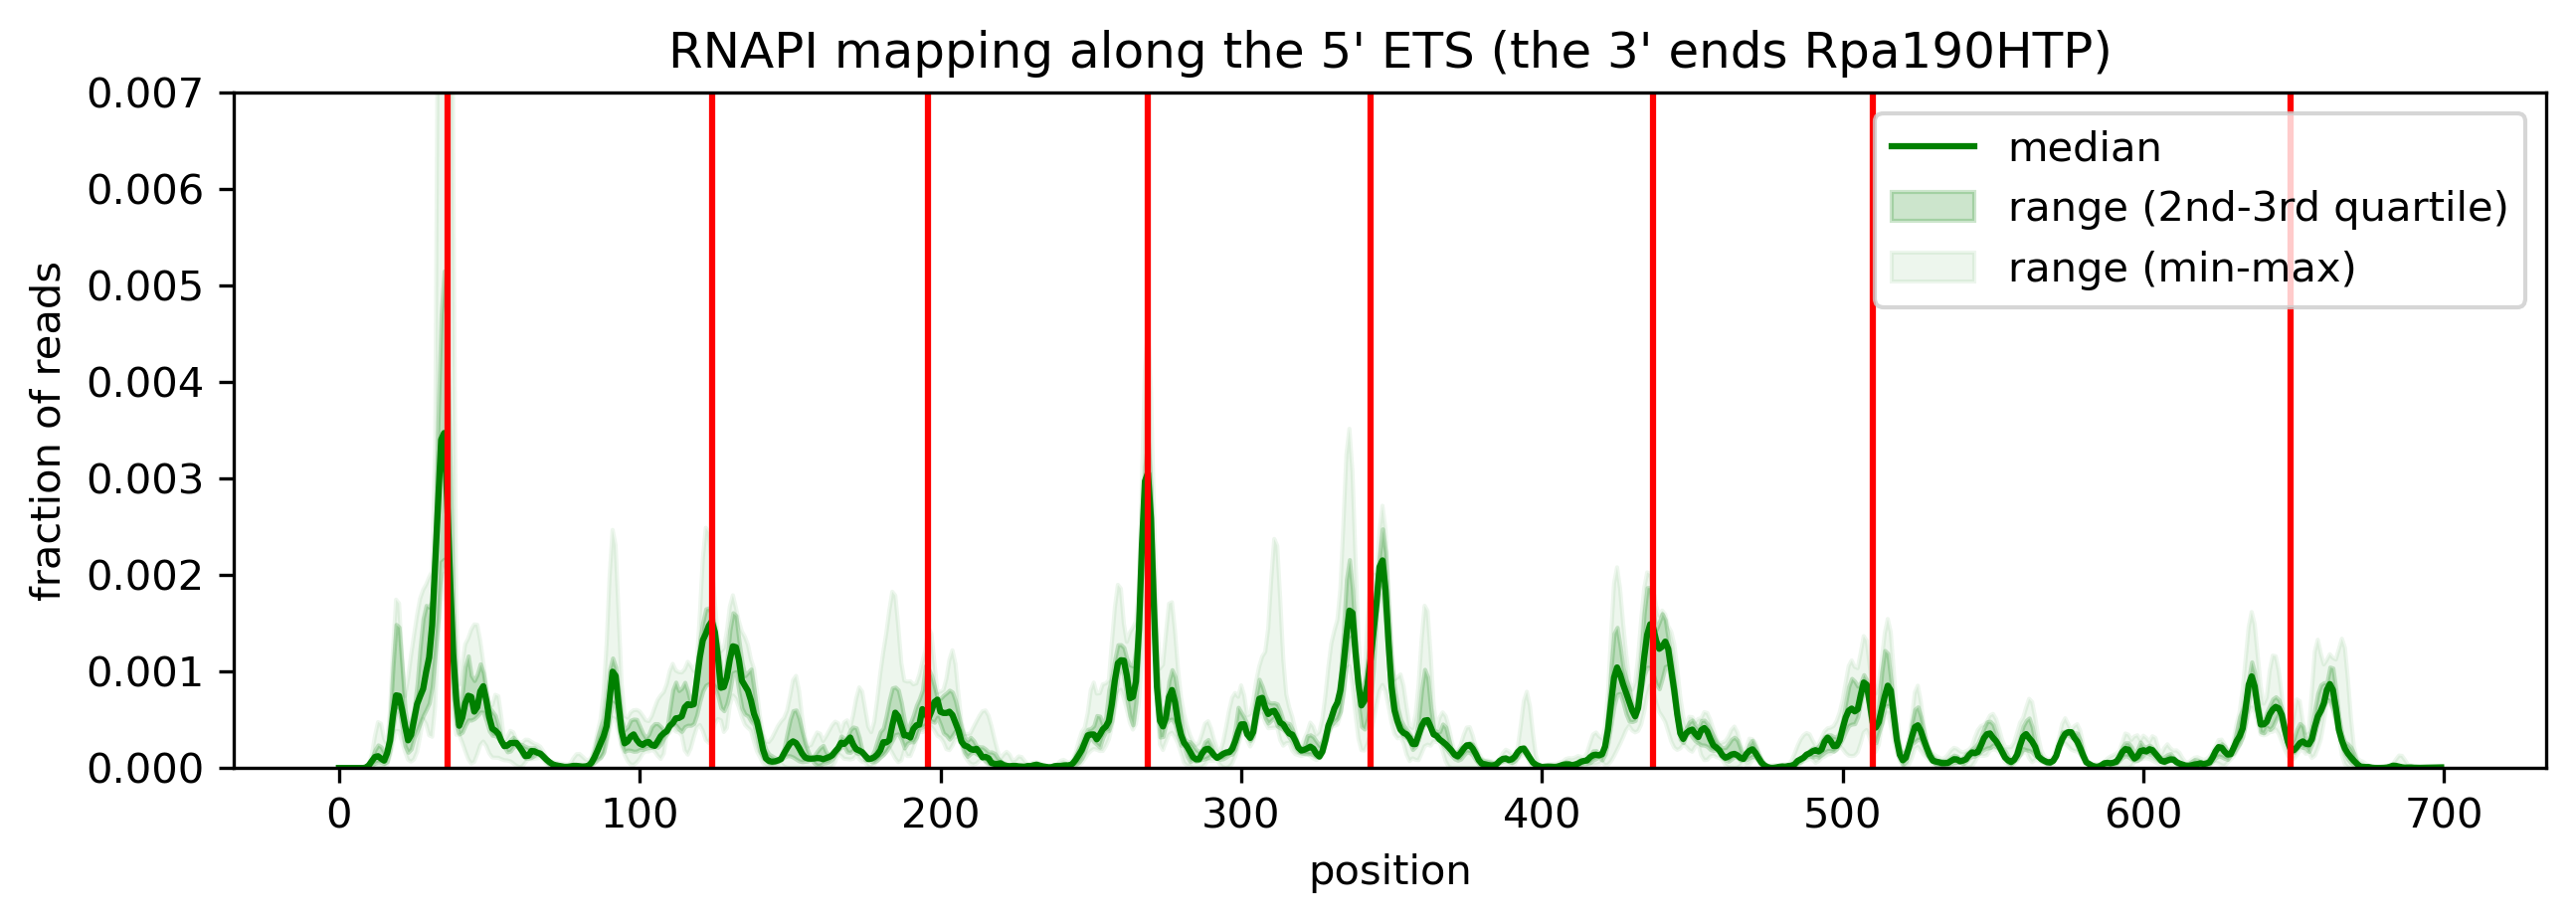

In [7]:
tt.plotting.plot_as_box_plot(df11_Rpa190_3end, title="RNAPI mapping along the 5' ETS (the 3' ends Rpa190HTP)",
                             dpi=300,ylim=(None,0.007), start=0+300, stop=700+300,figsize=(10,3),
                             h_lines=[i-300 for i in peaks],offset=300,fname='Fig_S4B.png')

tt.plotting.plot_as_box_plot(df11_Rpa190_3end, title="RNAPI mapping along the 5' ETS (the 3' ends Rpa190HTP)",
                             dpi=300,ylim=(None,0.007), start=0+300, stop=700+300,figsize=(10,3),
                             h_lines=[i-300 for i in loc_extr],offset=300,fname='Fig_S4B_v1.png')

# 5' ETS

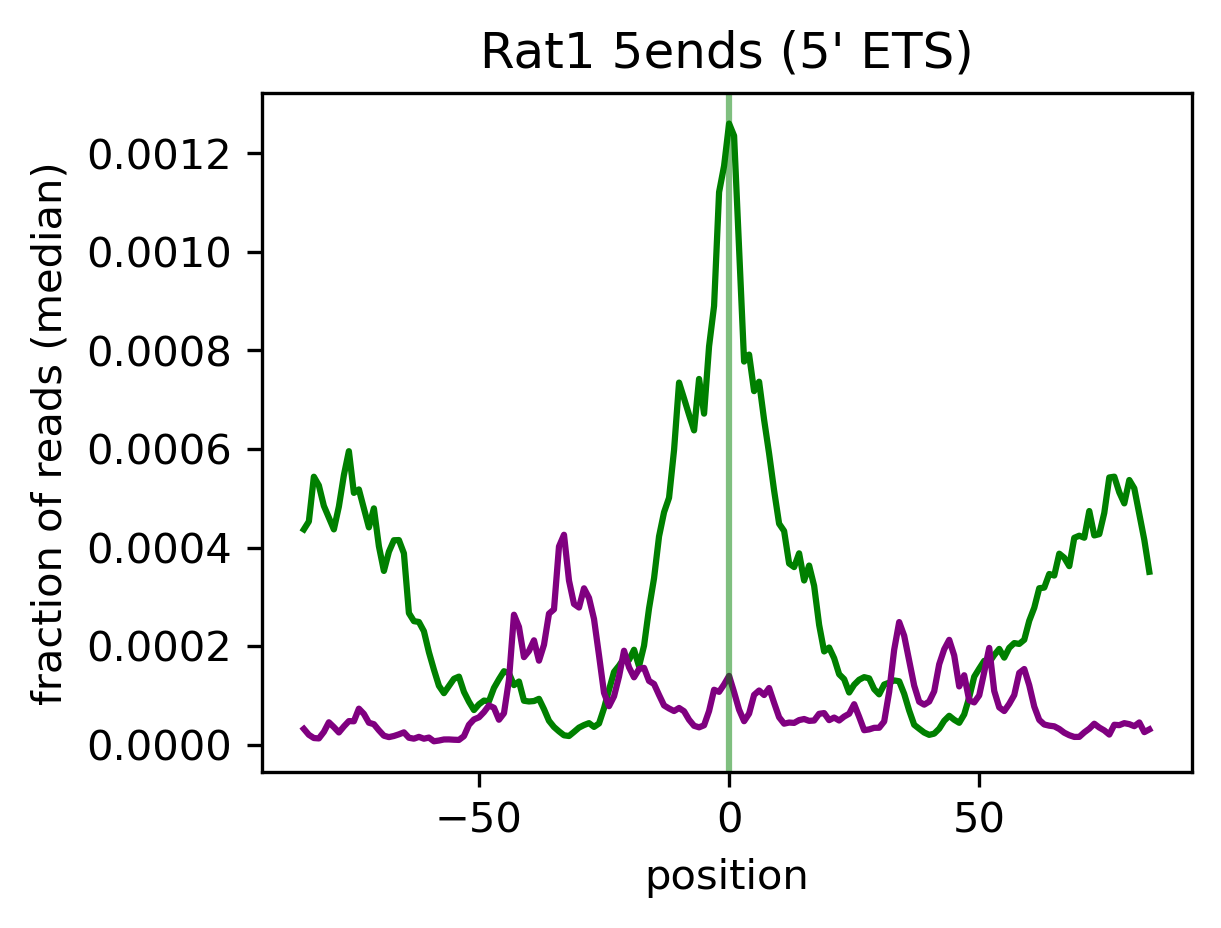

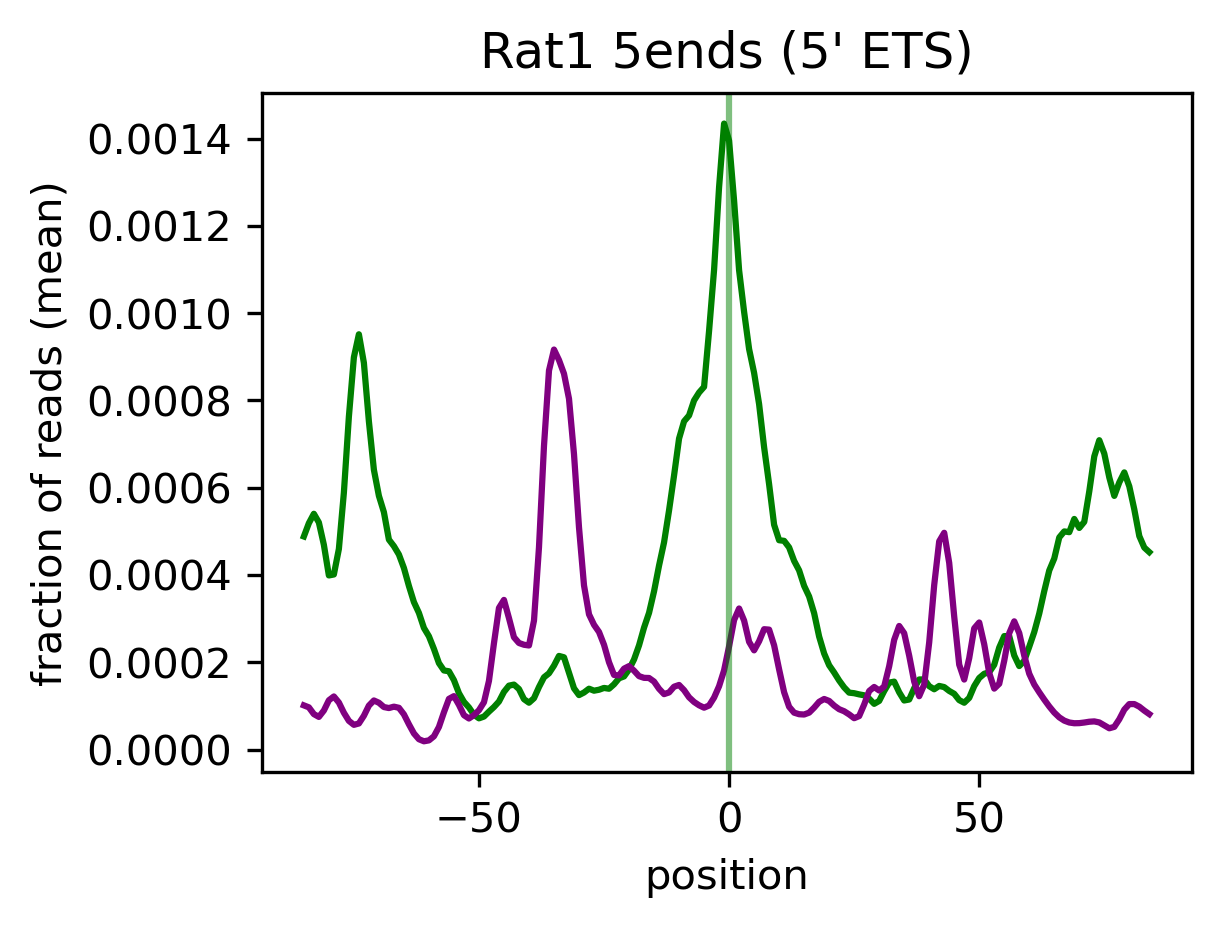

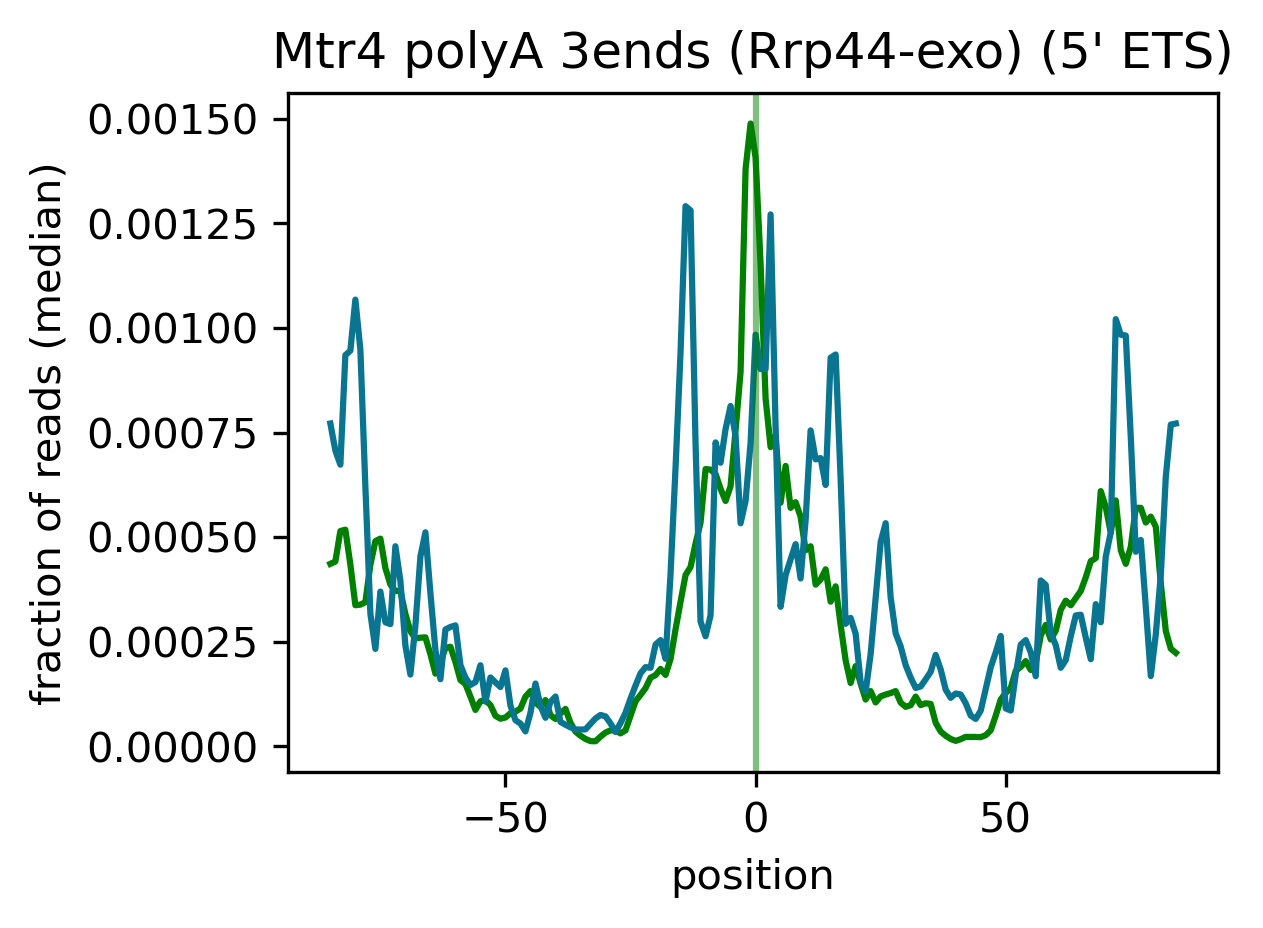

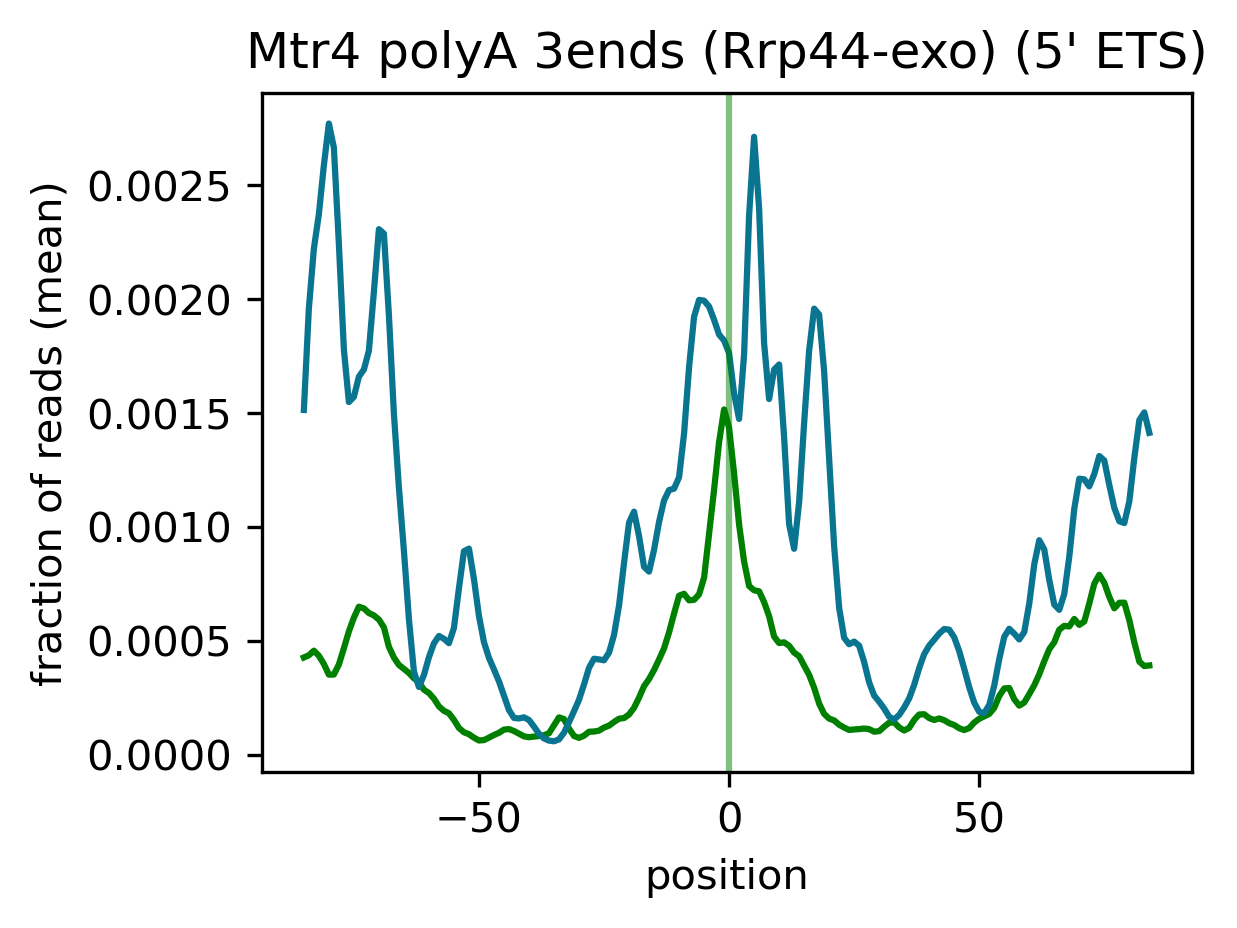

In [8]:
stop=1000
window = 85
elem=" (5' ETS)"

tt.plotting.cumulativePeaks(df11_Rpa190_3end, df2=df14_Rat1_5end, local_pos=peaks, dpi=300,
                        title="Rat1 5ends"+elem, start=None, stop=stop, window=window, figsize=(4,3),
                        color1='green', color2="purple", lc='green',fname="Fig_4Bmedian.png",use='median')

tt.plotting.cumulativePeaks(df11_Rpa190_3end, df2=df14_Rat1_5end, local_pos=peaks, dpi=300,
                        title="Rat1 5ends"+elem, start=None, stop=stop, window=window, figsize=(4,3),
                        color1='green', color2="purple", lc='green',fname="Fig_4B.png")

tt.plotting.cumulativePeaks(df11_Rpa190_3end, df2=df22_Mtr4Rrp44exo_polyA, local_pos=[i for i in peaks if i != 643], dpi=300,
                        title="Mtr4 polyA 3ends (Rrp44-exo)"+elem, start=None, stop=stop, window=window, figsize=(4,3),
                        color1='green', color2="#0A7590", lc='green',fname="Fig_4Dmedian.png",use='median')

tt.plotting.cumulativePeaks(df11_Rpa190_3end, df2=df22_Mtr4Rrp44exo_polyA, local_pos=[i for i in peaks if i != 643], dpi=300,
                        title="Mtr4 polyA 3ends (Rrp44-exo)"+elem, start=None, stop=stop, window=window, figsize=(4,3),
                        color1='green', color2="#0A7590", lc='green',fname="Fig_4D.png")

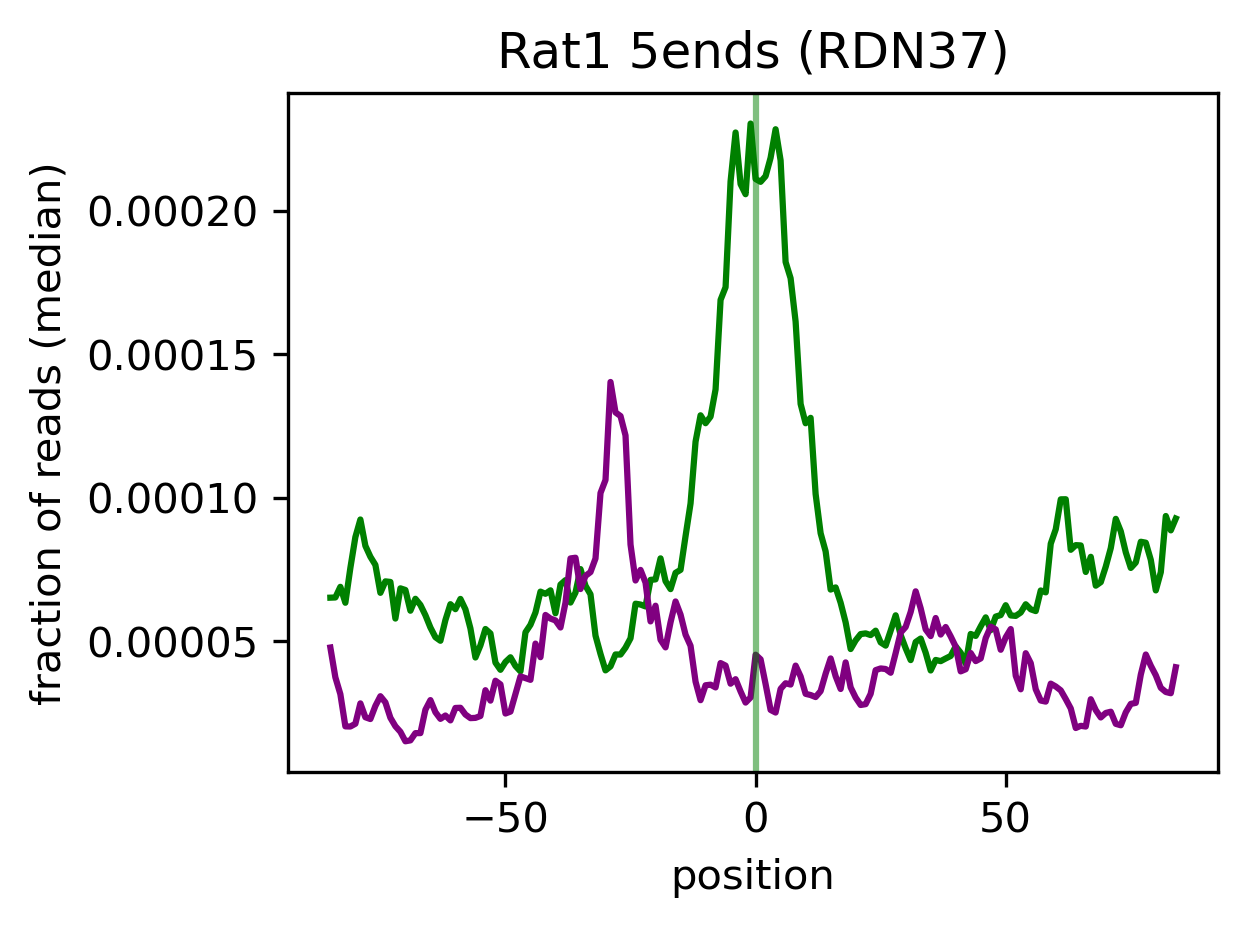

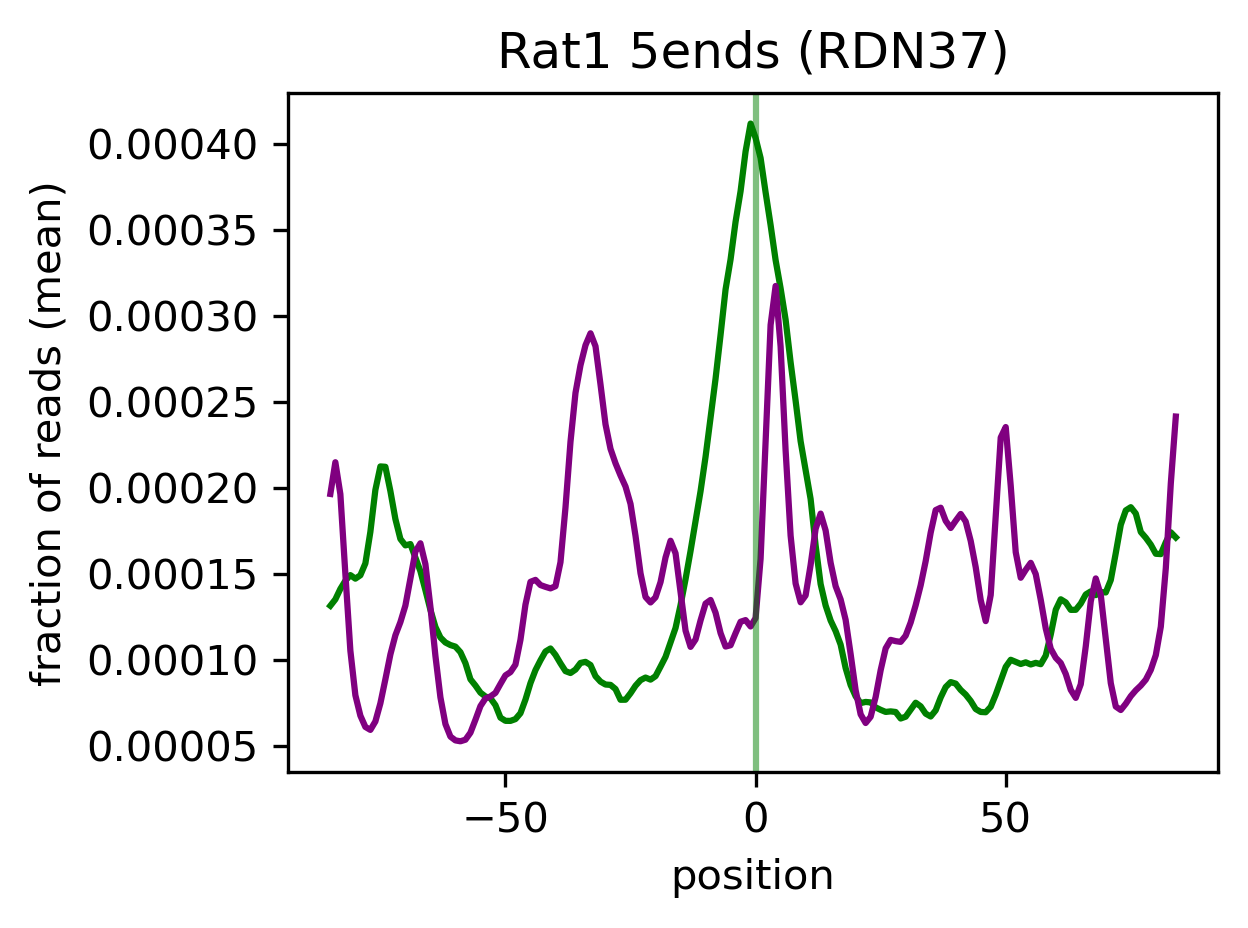

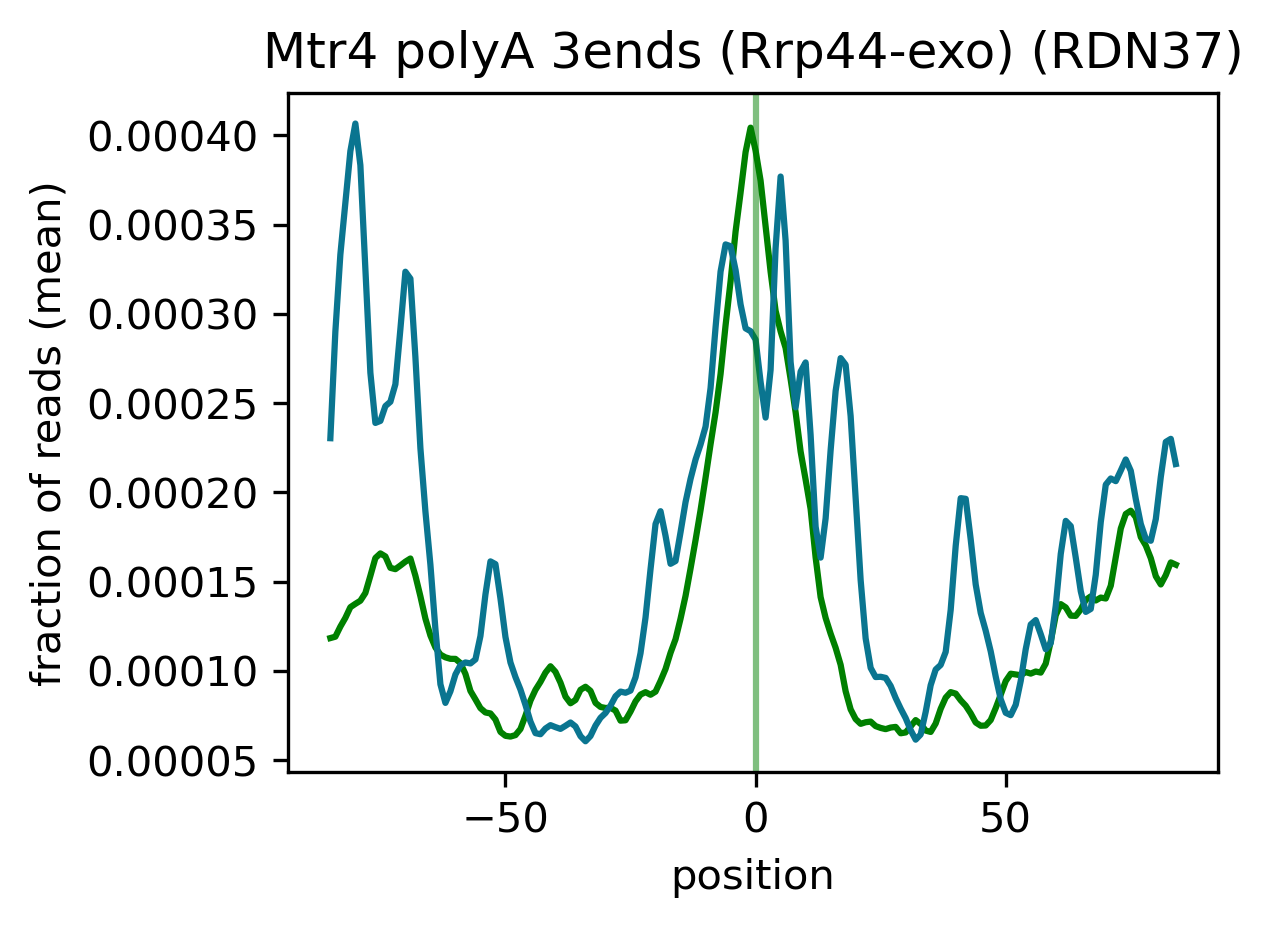

In [9]:
stop=7100
elem=" (RDN37)"

tt.plotting.cumulativePeaks(df11_Rpa190_3end, df2=df14_Rat1_5end, local_pos=peaks, dpi=300,
                        title="Rat1 5ends"+elem, start=None, stop=stop, window=window, figsize=(4,3),
                        color1='green', color2="purple", lc='green',fname="Fig_4Bmedian_v2.png",use='median')

tt.plotting.cumulativePeaks(df11_Rpa190_3end, df2=df14_Rat1_5end, local_pos=peaks, dpi=300,
                        title="Rat1 5ends"+elem, start=None, stop=stop, window=window, figsize=(4,3),
                        color1='green', color2="purple", lc='green',fname="Fig_4B_v2.png")

tt.plotting.cumulativePeaks(df11_Rpa190_3end, df2=df22_Mtr4Rrp44exo_polyA, local_pos=[i for i in peaks if i != 643], dpi=300,
                        title="Mtr4 polyA 3ends (Rrp44-exo)"+elem, start=None, stop=stop, window=window, figsize=(4,3),
                        color1='green', color2="#0A7590", lc='green',fname="Fig_4D_v2.png")

## Top2

In [10]:
tt.profiles.preprocess(df04_RDN37_raw, let_in=['Top2HTP'], 
                                     let_out=['hmo1','0s','25rDNA','UVA'],stats=False, ntotal_param=False).sum()


Experiments: 
['26A_MW160713_Top2HTP_wt_raw', '26A_mix1_MW160713_Top2HTP_wt_raw', '26B_MW160713_Top2HTP_wt_raw', '26A_mix2_MW160713_Top2HTP_wt_raw', '11B_MW151027_Top2HTP_wt_raw']


26A_MW160713_Top2HTP_wt_raw          583993.71
26A_mix1_MW160713_Top2HTP_wt_raw     230762.64
26B_MW160713_Top2HTP_wt_raw         1142130.20
26A_mix2_MW160713_Top2HTP_wt_raw     164362.84
11B_MW151027_Top2HTP_wt_raw          833741.93
dtype: float64

In [11]:
df24_Top2_read = tt.profiles.preprocess(df04_RDN37_raw, let_in=['Top2HTP'], stats=True)

df25_Top2_5end = tt.profiles.preprocess(df02_RDN37_5end, let_in=['Top2HTP'], stats=True)

df26_Top2_3end = tt.profiles.preprocess(df01_RDN37_3end, let_in=['Top2HTP'], stats=True)

df27_Top2_polyA = tt.profiles.preprocess(df03_RDN37_polyA, let_in=['Top2HTP'],stats=True)

Experiments: 
['26A_MW160713_Top2HTP_wt_raw', '26A_mix1_MW160713_Top2HTP_wt_raw', '26B_MW160713_Top2HTP_wt_raw', '26A_mix2_MW160713_Top2HTP_wt_raw', '11B_MW151027_Top2HTP_wt_raw']


/home/tturowski/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


Experiments: 
['26A_mix2_MW160713_Top2HTP_wt_PROFILE_5end', '26B_MW160713_Top2HTP_wt_PROFILE_5end', '26A_mix1_MW160713_Top2HTP_wt_PROFILE_5end', '26A_MW160713_Top2HTP_wt_PROFILE_5end', '11B_MW151027_Top2HTP_wt_PROFILE_5end']
Experiments: 
['26B_MW160713_Top2HTP_wt_PROFILE_3end', '11B_MW151027_Top2HTP_wt_PROFILE_3end', '26A_mix2_MW160713_Top2HTP_wt_PROFILE_3end', '26A_mix1_MW160713_Top2HTP_wt_PROFILE_3end', '26A_MW160713_Top2HTP_wt_PROFILE_3end']
Experiments: 
['26A_MW160713_Top2HTP_wt_PROFILE_3end_polyA', '26A_mix1_MW160713_Top2HTP_wt_PROFILE_3end_polyA', '26A_mix2_MW160713_Top2HTP_wt_PROFILE_3end_polyA', '11B_MW151027_Top2HTP_wt_PROFILE_3end_polyA', '26B_MW160713_Top2HTP_wt_PROFILE_3end_polyA']


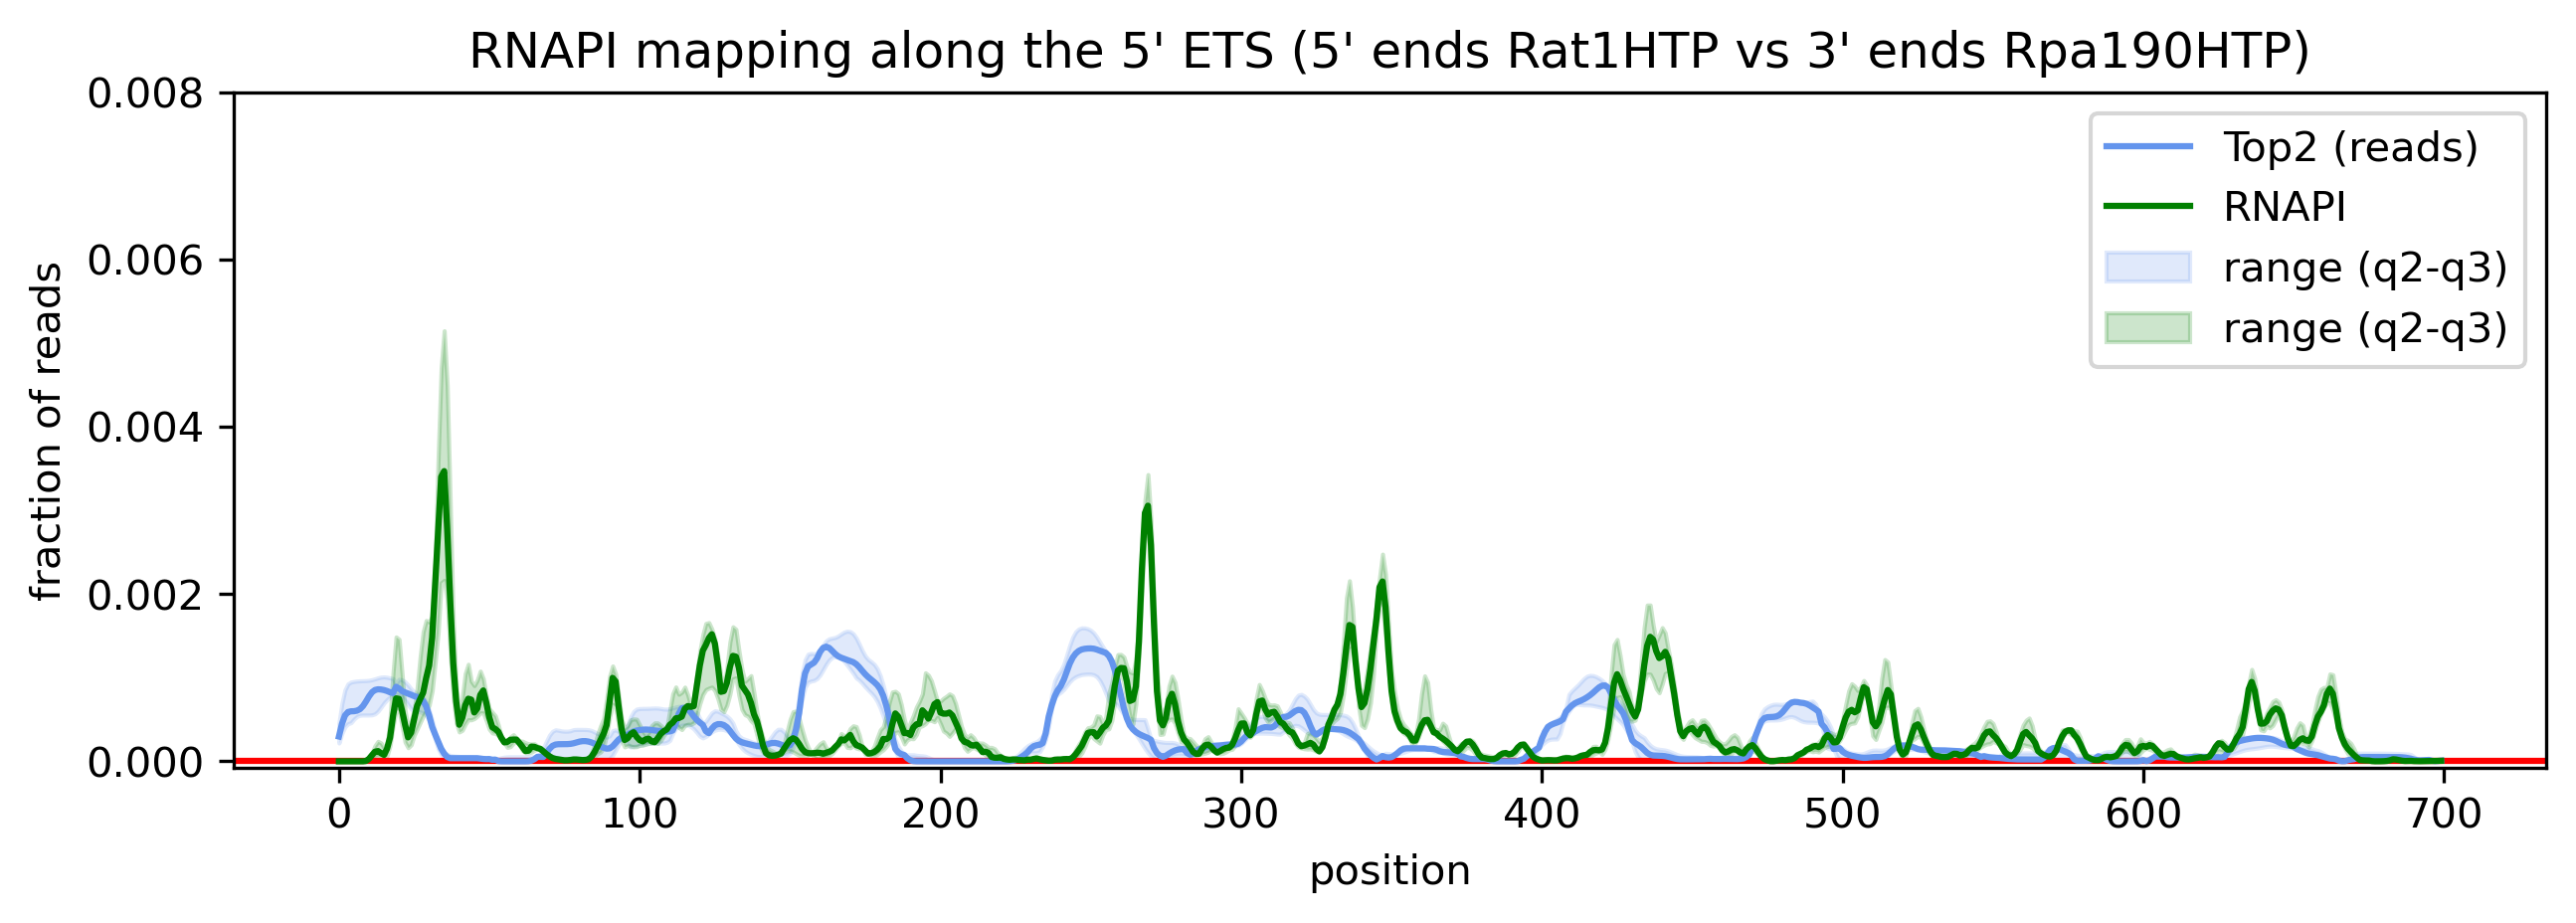

In [12]:
tt.plotting.plot_to_compare(ref=df11_Rpa190_3end, df=df24_Top2_read,figsize=(10,3),ref_label="RNAPI",label="Top2 (reads)",
                           title="RNAPI mapping along the 5' ETS (5' ends Rat1HTP vs 3' ends Rpa190HTP)",
                           dpi=300,offset=300, ylim=(None,0.008),
                           start=0+300, stop=700+300, color2="cornflowerblue",
                           fname='Fig_4F_reads.png')

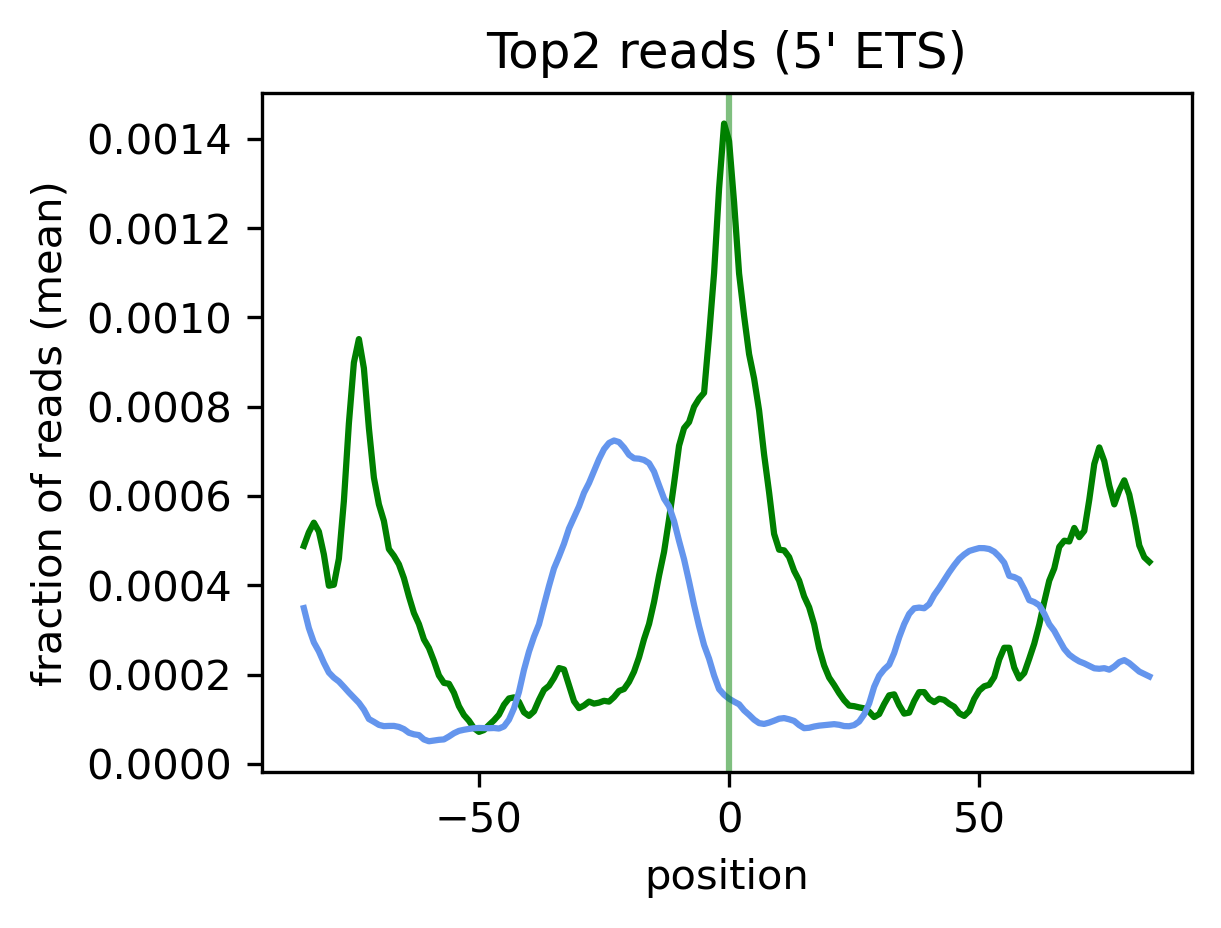

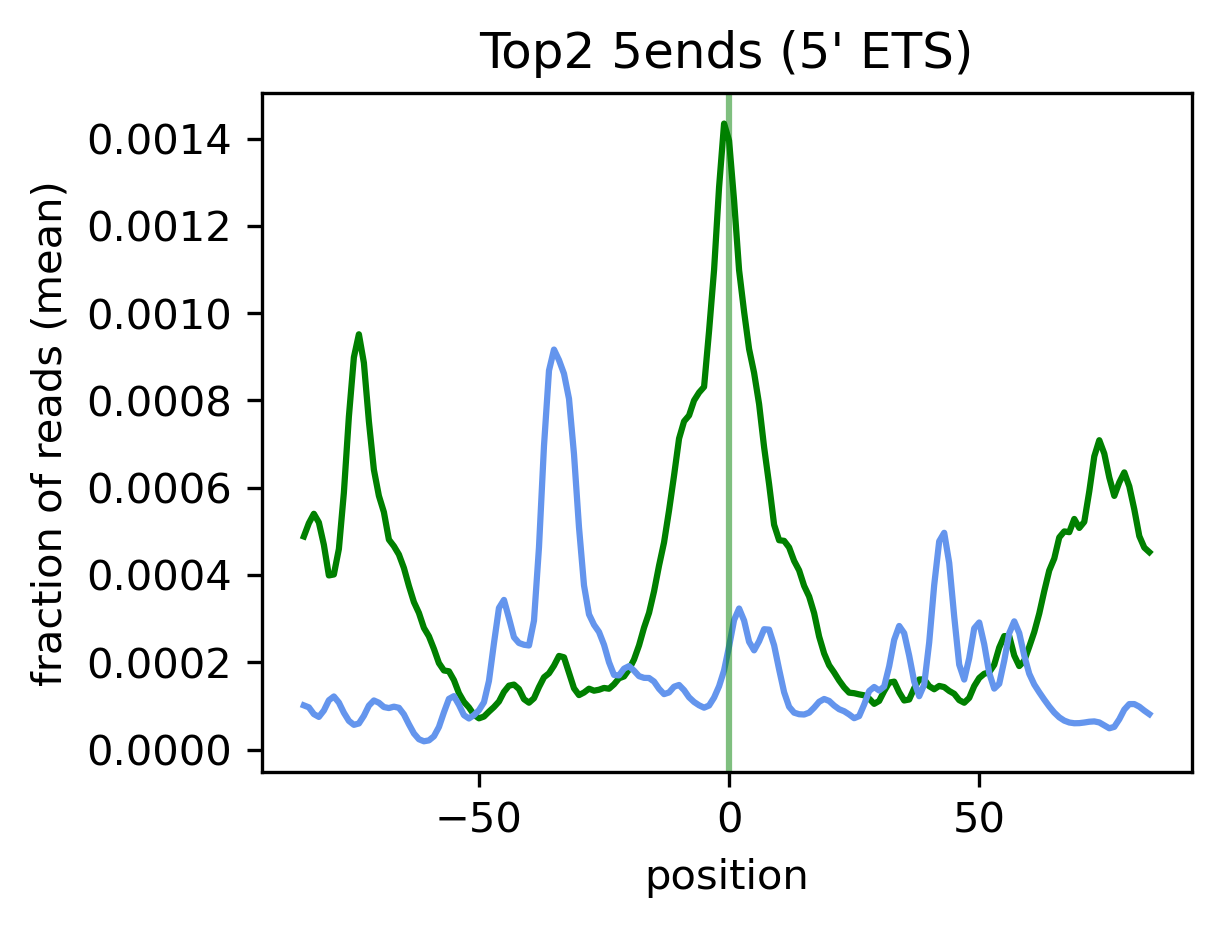

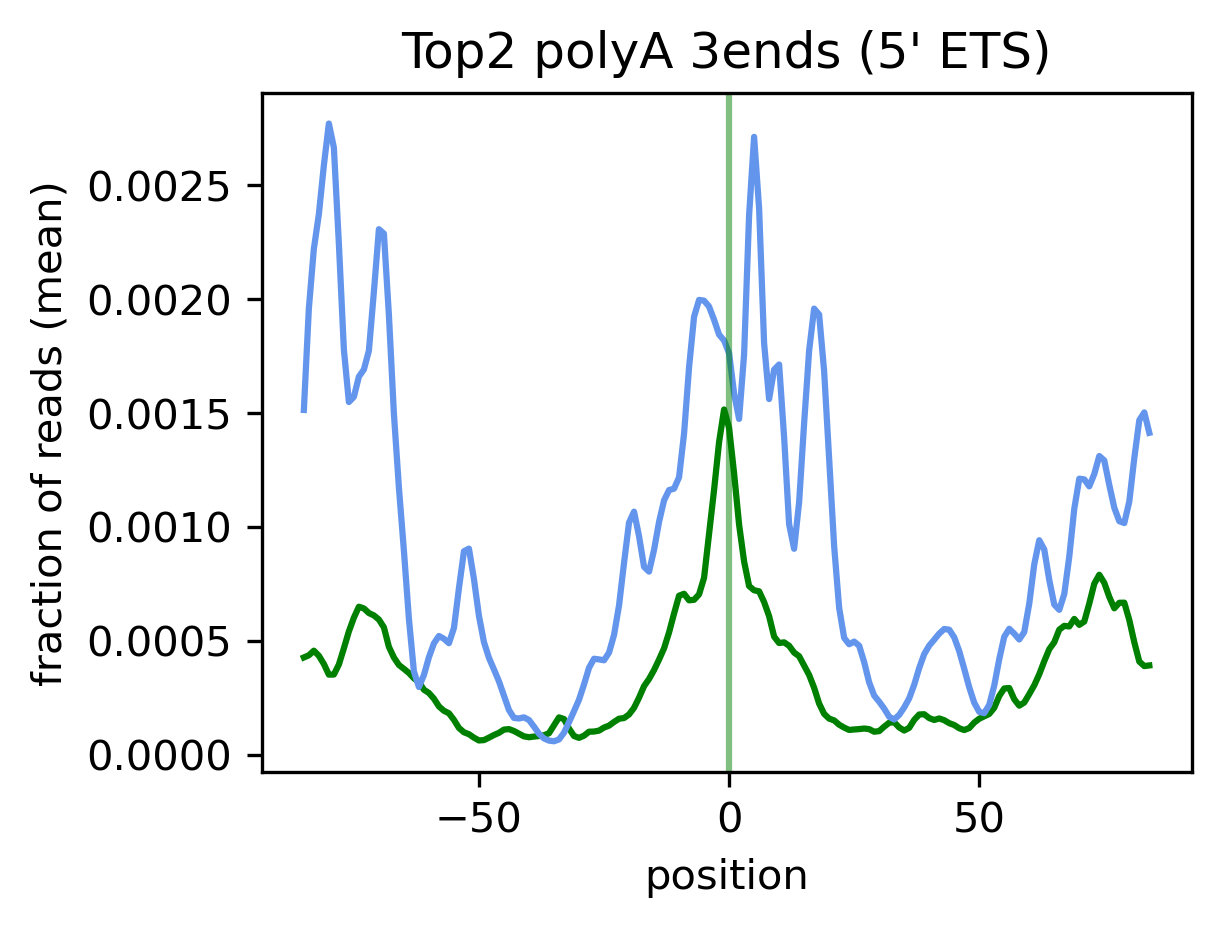

In [13]:
stop=1000
window = 85
elem=" (5' ETS)"

tt.plotting.cumulativePeaks(df11_Rpa190_3end, df2=df24_Top2_read, local_pos=peaks, dpi=300,
                        title="Top2 reads"+elem, start=None, stop=stop, window=window, figsize=(4,3),
                        color1='green', color2="cornflowerblue", lc='green',fname="Fig_S4E_read.png")

tt.plotting.cumulativePeaks(df11_Rpa190_3end, df2=df14_Rat1_5end, local_pos=peaks, dpi=300,
                        title="Top2 5ends"+elem, start=None, stop=stop, window=window, figsize=(4,3),
                        color1='green', color2="cornflowerblue", lc='green',fname="Fig_S4F_5end.png")

tt.plotting.cumulativePeaks(df11_Rpa190_3end, df2=df22_Mtr4Rrp44exo_polyA, local_pos=[i for i in peaks if i != 643], dpi=300,
                        title="Top2 polyA 3ends"+elem, start=None, stop=stop, window=window, figsize=(4,3),
                        color1='green', color2="cornflowerblue", lc='green',fname="Fig_S4G_polyA.png")

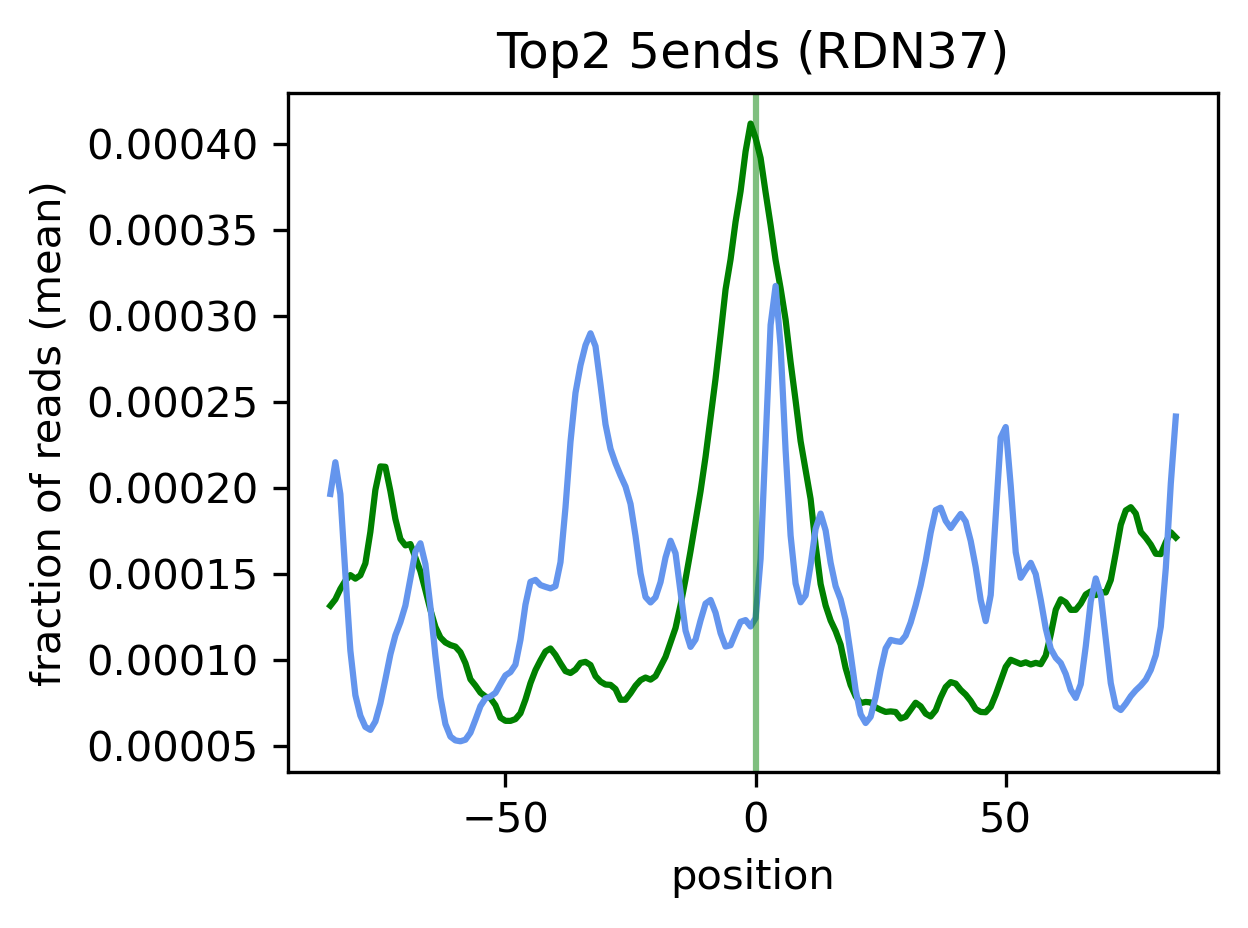

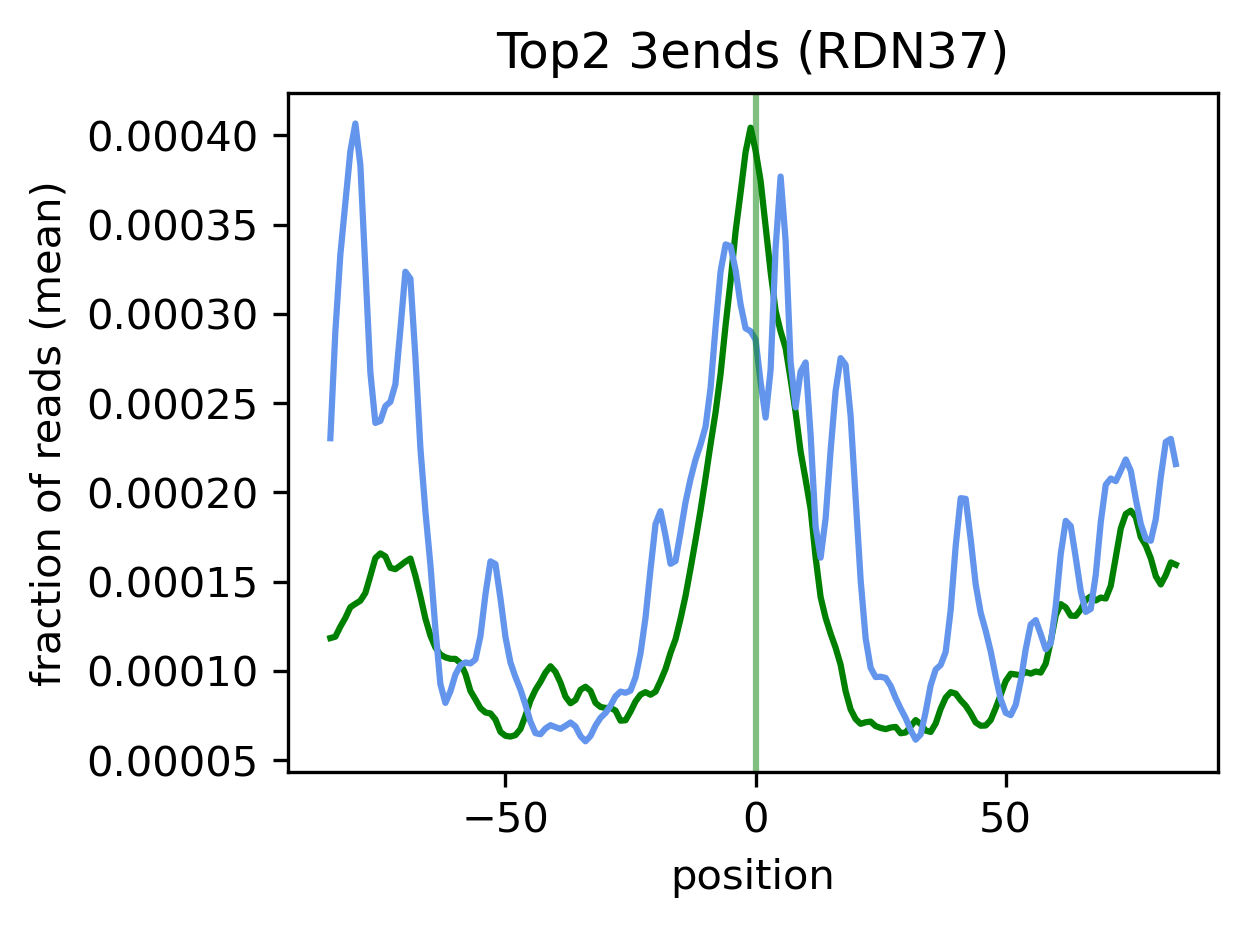

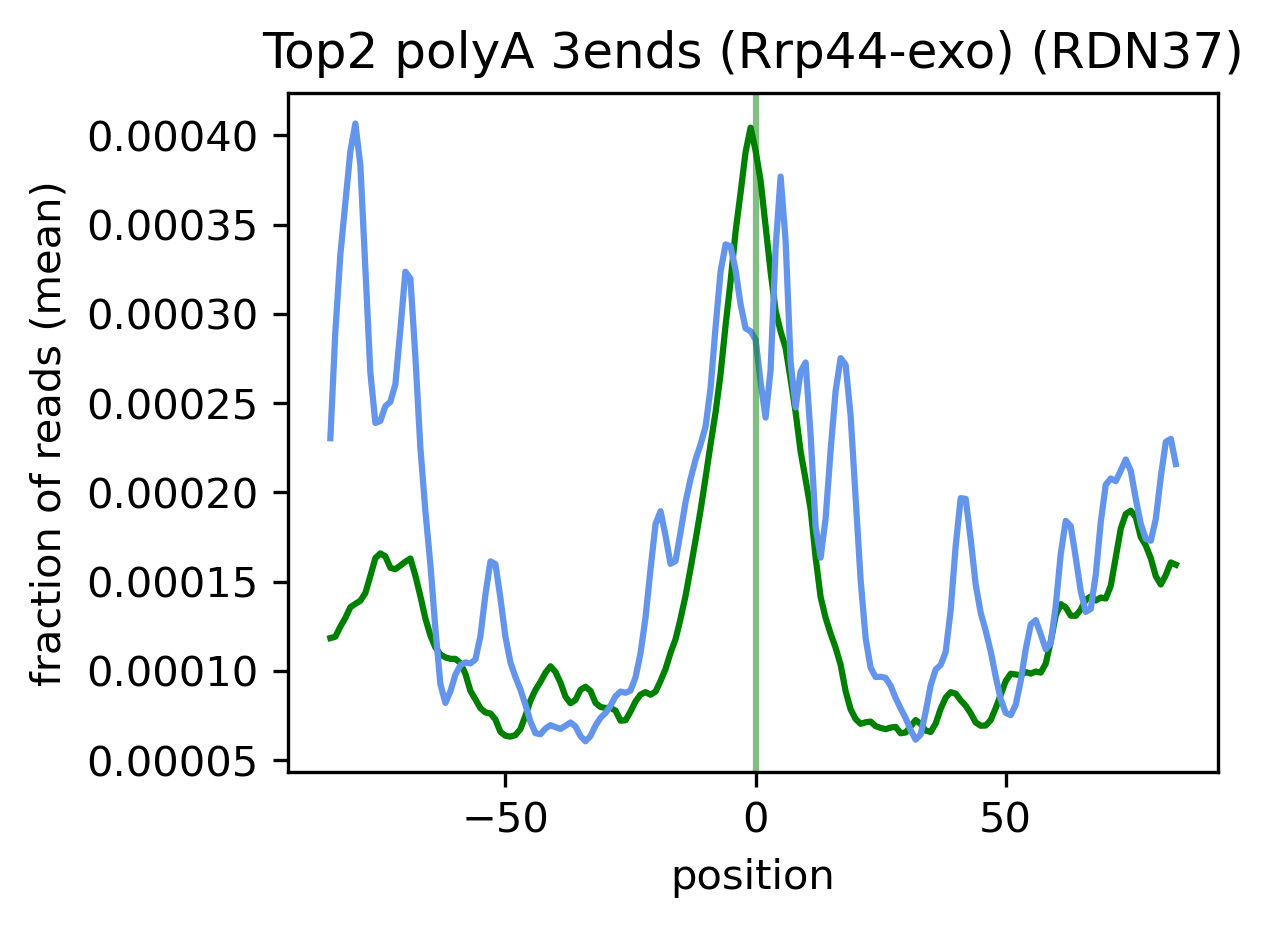

In [14]:
stop=7100
elem=" (RDN37)"

tt.plotting.cumulativePeaks(df11_Rpa190_3end, df2=df14_Rat1_5end, local_pos=peaks, dpi=300,
                        title="Top2 5ends"+elem, start=None, stop=stop, window=window, figsize=(4,3),
                        color1='green', color2="cornflowerblue", lc='green',fname="Fig_4E_5end_v2.png")

tt.plotting.cumulativePeaks(df11_Rpa190_3end, df2=df22_Mtr4Rrp44exo_polyA, local_pos=[i for i in peaks if i != 643], dpi=300,
                        title="Top2 3ends"+elem, start=None, stop=stop, window=window, figsize=(4,3),
                        color1='green', color2="cornflowerblue", lc='green',fname="Fig_4E_3end_v2.png")

tt.plotting.cumulativePeaks(df11_Rpa190_3end, df2=df22_Mtr4Rrp44exo_polyA, local_pos=[i for i in peaks if i != 643], dpi=300,
                        title="Top2 polyA 3ends (Rrp44-exo)"+elem, start=None, stop=stop, window=window, figsize=(4,3),
                        color1='green', color2="cornflowerblue", lc='green',fname="Fig_4E_polyA_v2.png")